In [16]:
!pip install pandas networkx matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [17]:
!pip install pandas networkx 

Defaulting to user installation because normal site-packages is not writeable


## Data Loading

In [17]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def extract_graph(graph_path, nodes_properties):
    edges_df = pd.read_csv(f'{graph_path}/edges.csv', header=0, names=['source', 'target'])
    nodes_df = pd.read_csv(f'{graph_path}/nodes.csv', header=0, names=nodes_properties)

    # Create a graph using the edges dataframe
    G = nx.from_pandas_edgelist(edges_df, 'source', 'target')

    # Add node attributes from nodes_df (matching by 'index' column)
    for _, row in nodes_df.iterrows():
        if row['index'] in G.nodes:
            G.nodes[row['index']]['label'] = row['label']
            G.nodes[row['index']]['value'] = row['value']
    return G

def plot_graph_with_attributes(G, attribute_name, title, seed=42, node_size=500, font_size=10):
    node_labels = {node: str(node) for node in G.nodes} if attribute_name == 'index' else {node: G.nodes[node].get(attribute_name, '') for node in G.nodes}
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=seed) 
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=node_size, node_color='lightblue', font_size=font_size)
    plt.title(title)
    plt.show()


def print_graph_metrics(G, graph_name, seed=42, node_size=500, font_size=10):
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    avg_degree = sum(dict(G.degree()).values()) / num_nodes
    degree_distribution = [deg for node, deg in G.degree()]

    # Plot Degree Distribution
    plt.figure(figsize=(10, 6))
    plt.hist(degree_distribution, bins=range(min(degree_distribution), max(degree_distribution) + 1), alpha=0.75)
    plt.title(f'{graph_name} Dataset Degree Distribution')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Print some network metrics
    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")
    print(f"Average degree: {avg_degree:.2f}")
    print(f"Max degree: {max(degree_distribution)}")
    print(f"Min degree: {min(degree_distribution)}")
    plot_graph_with_attributes(G, 'index', f'{graph_name} Network Graph with Node Indexes', seed=seed, node_size=node_size, font_size=font_size)
    plot_graph_with_attributes(G, 'label', f'{graph_name} Network Graph with Node Labels', seed=seed, node_size=node_size, font_size=font_size)
    plot_graph_with_attributes(G, 'value', f'{graph_name} Network Graph with Node Values', seed=seed, node_size=node_size, font_size=font_size)


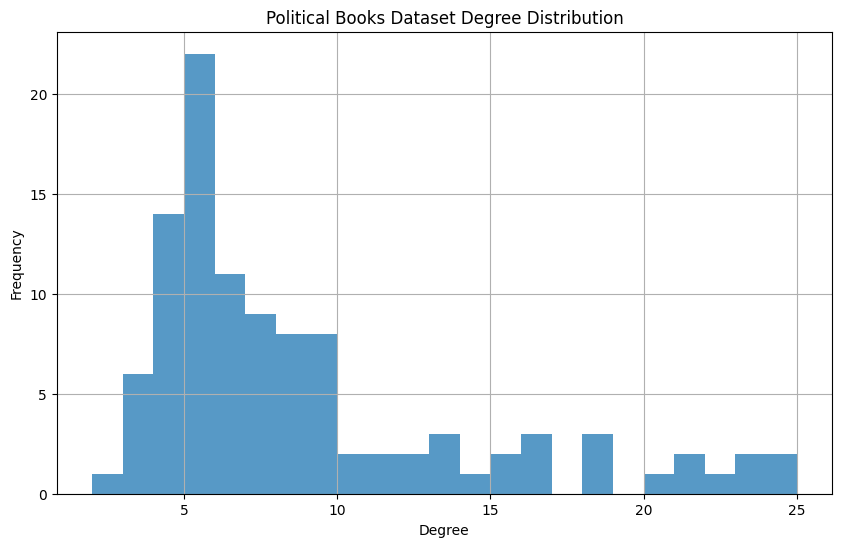

Number of nodes: 105
Number of edges: 441
Average degree: 8.40
Max degree: 25
Min degree: 2


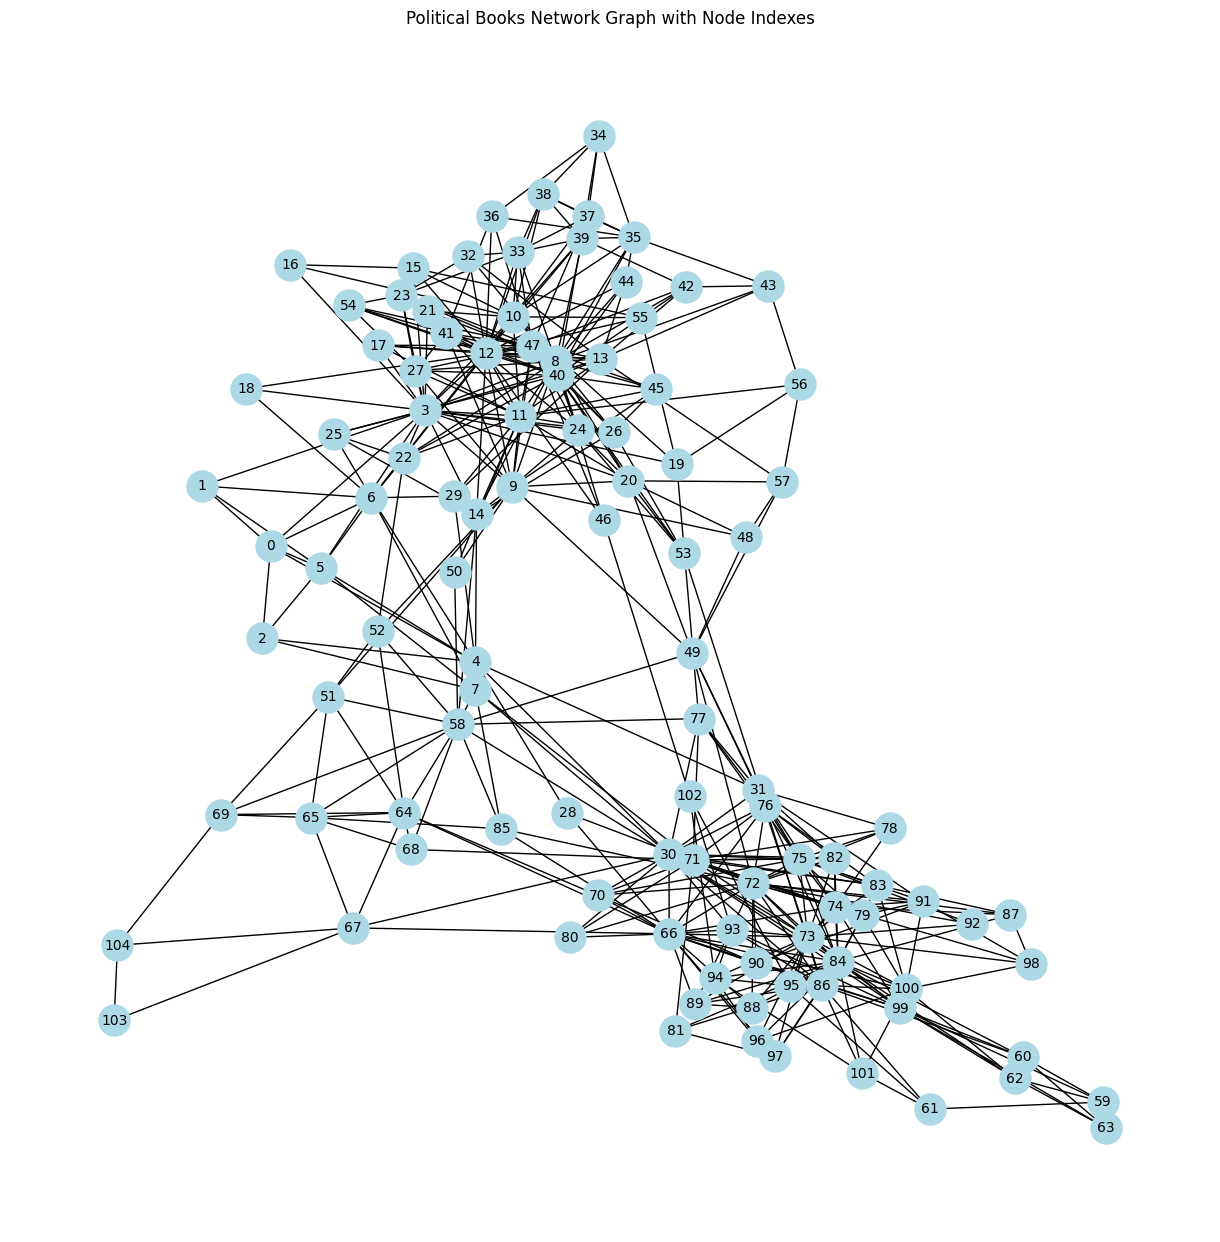

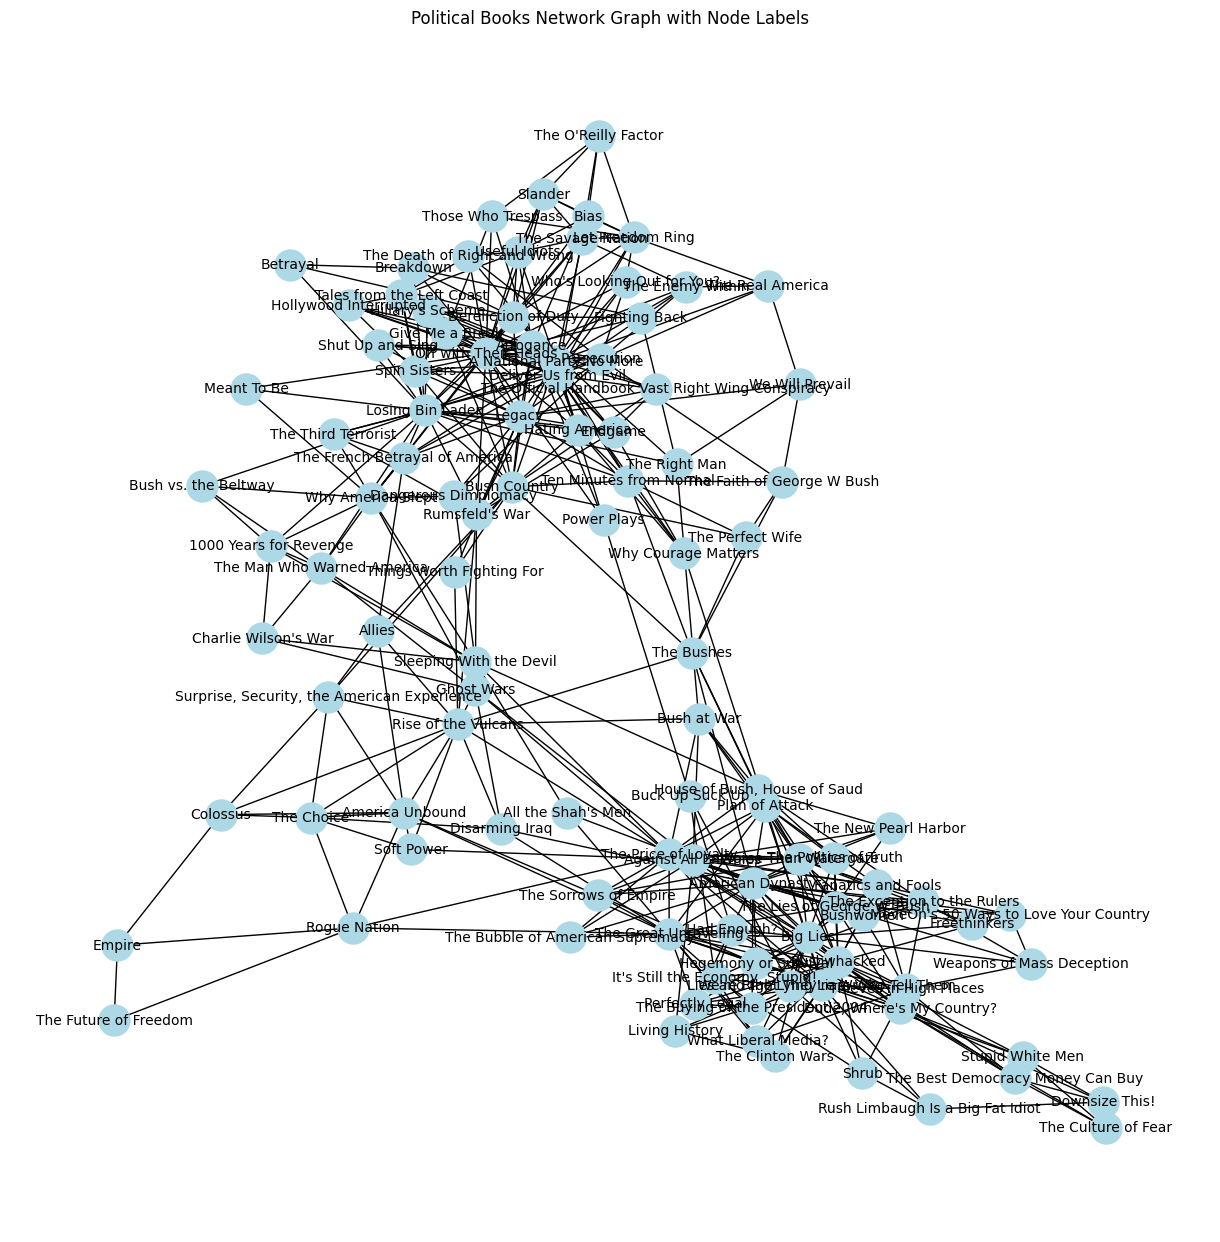

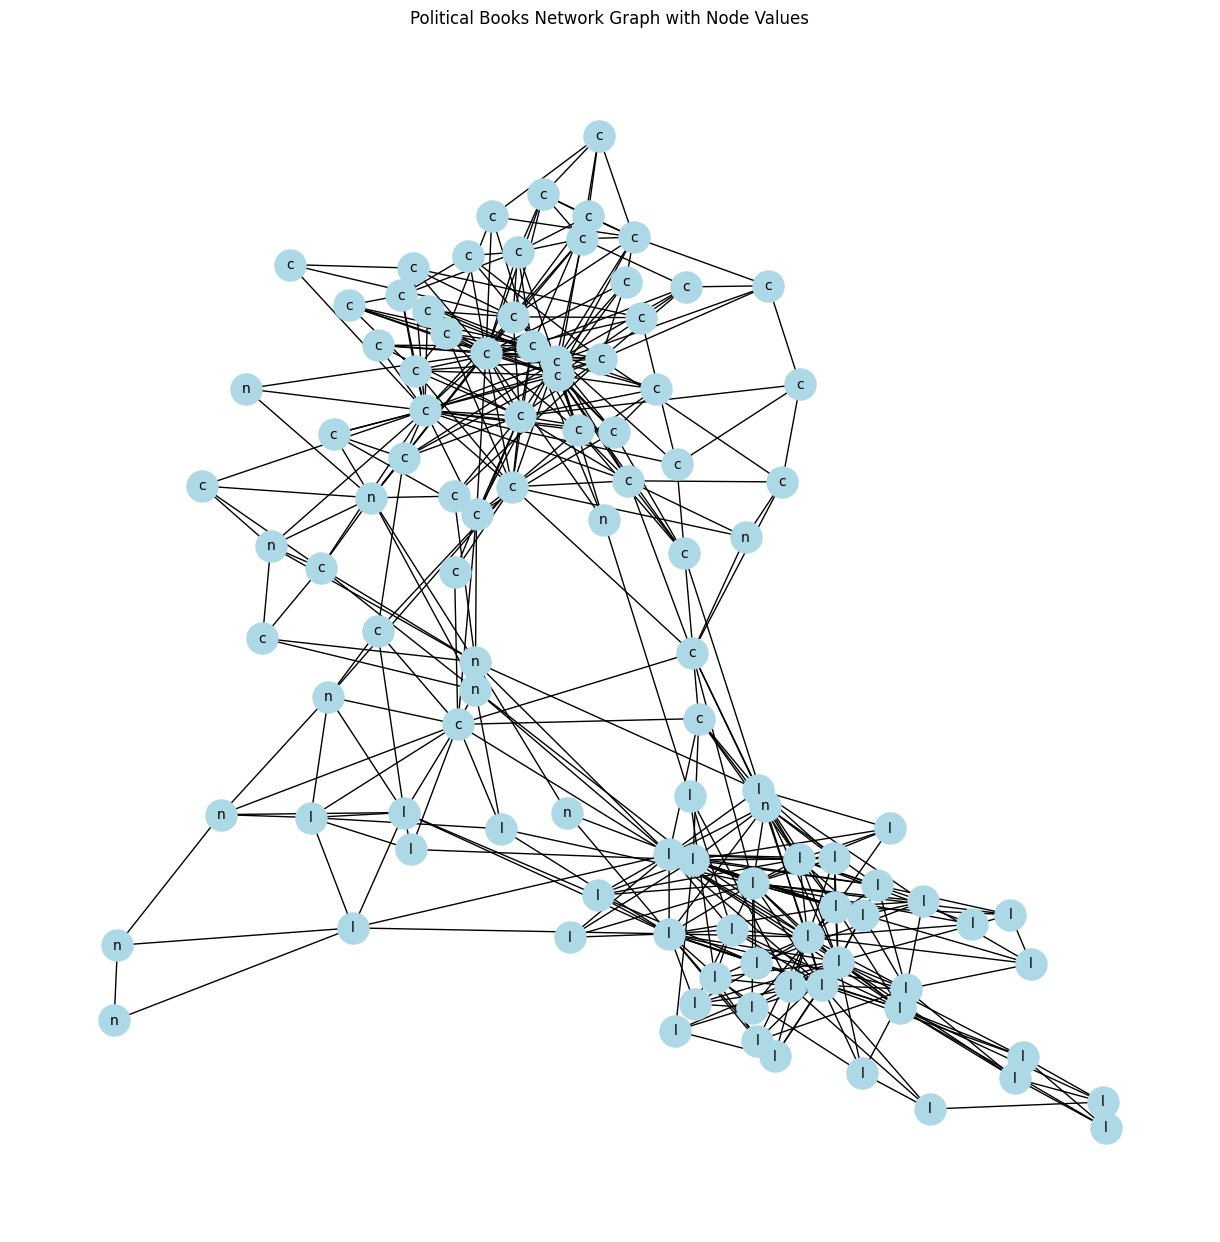

In [18]:
POLITICAL_BOOKS_DATASET_DIR = './data/polbooks'
POLITICAL_BOOKS_DATASET_NAME = 'Political Books'

G_books = extract_graph(POLITICAL_BOOKS_DATASET_DIR, nodes_properties=['index', 'label', 'value', '_pos'])
print_graph_metrics(G_books, POLITICAL_BOOKS_DATASET_NAME)

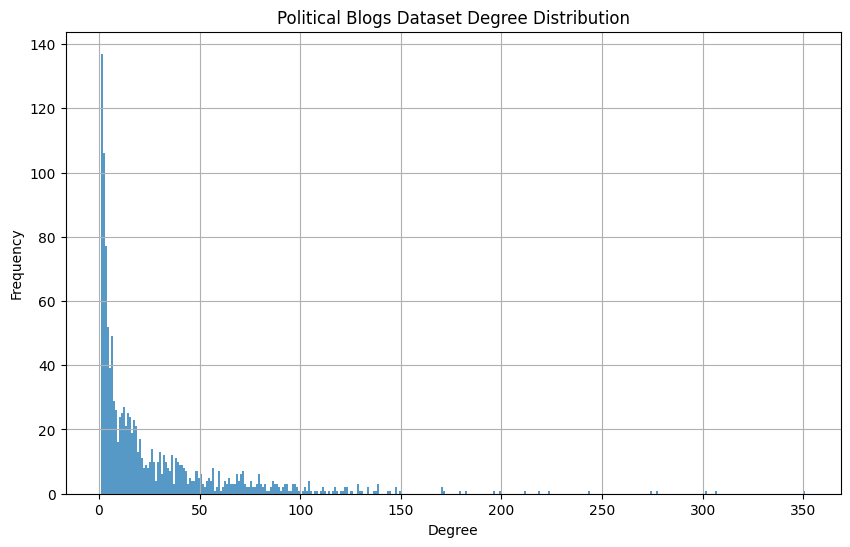

Number of nodes: 1224
Number of edges: 16718
Average degree: 27.32
Max degree: 351
Min degree: 1


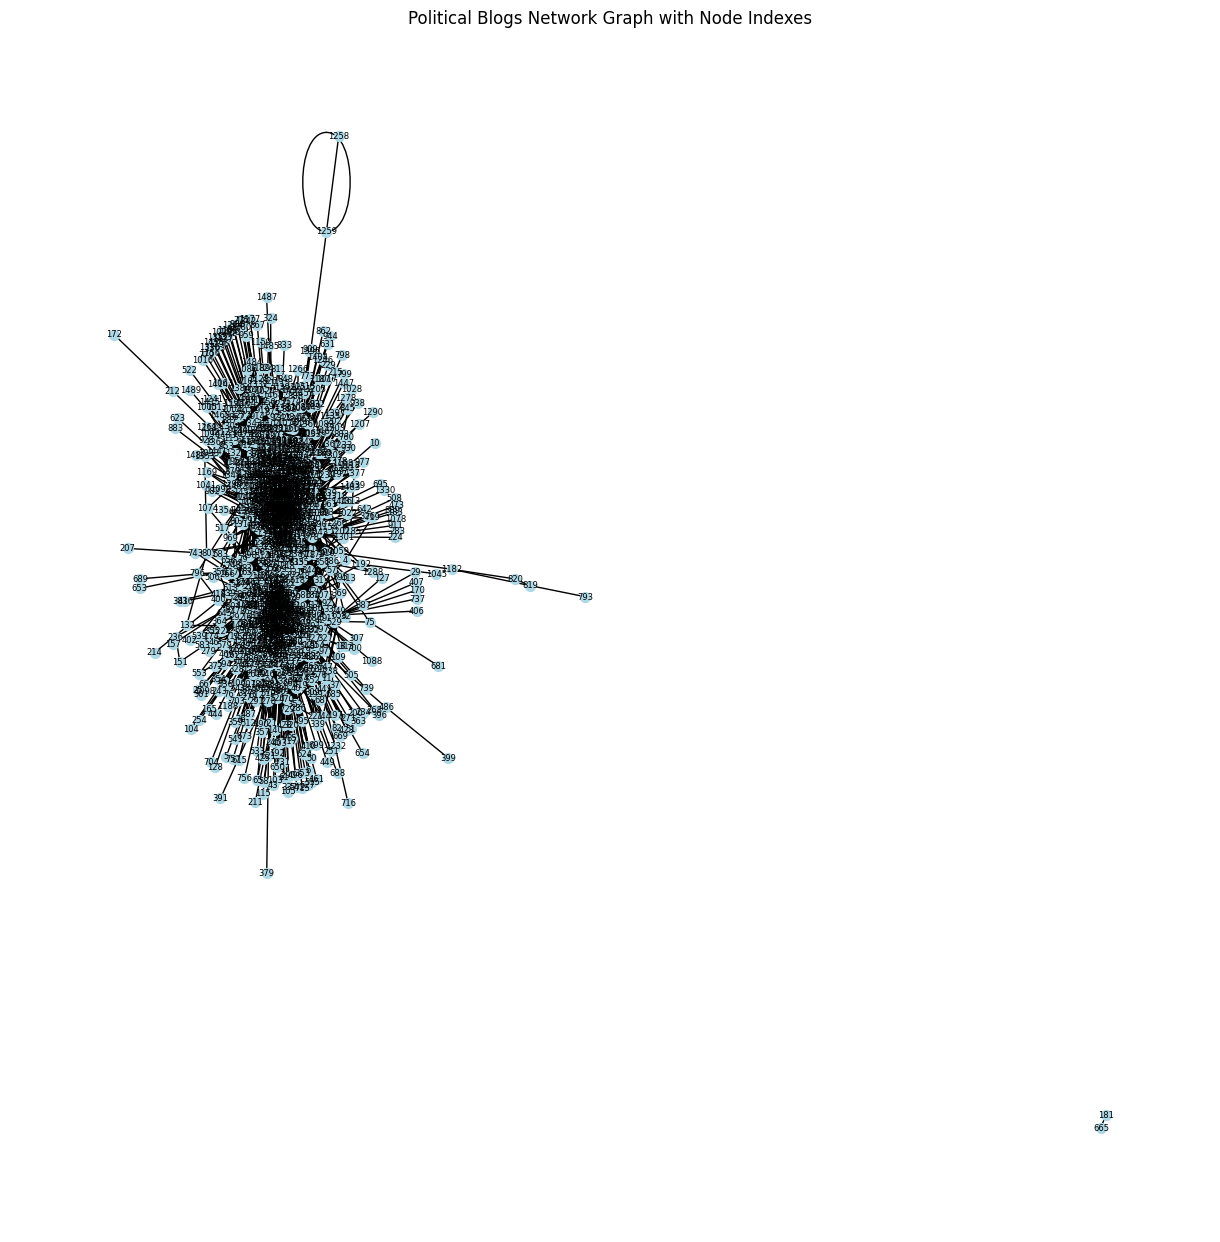

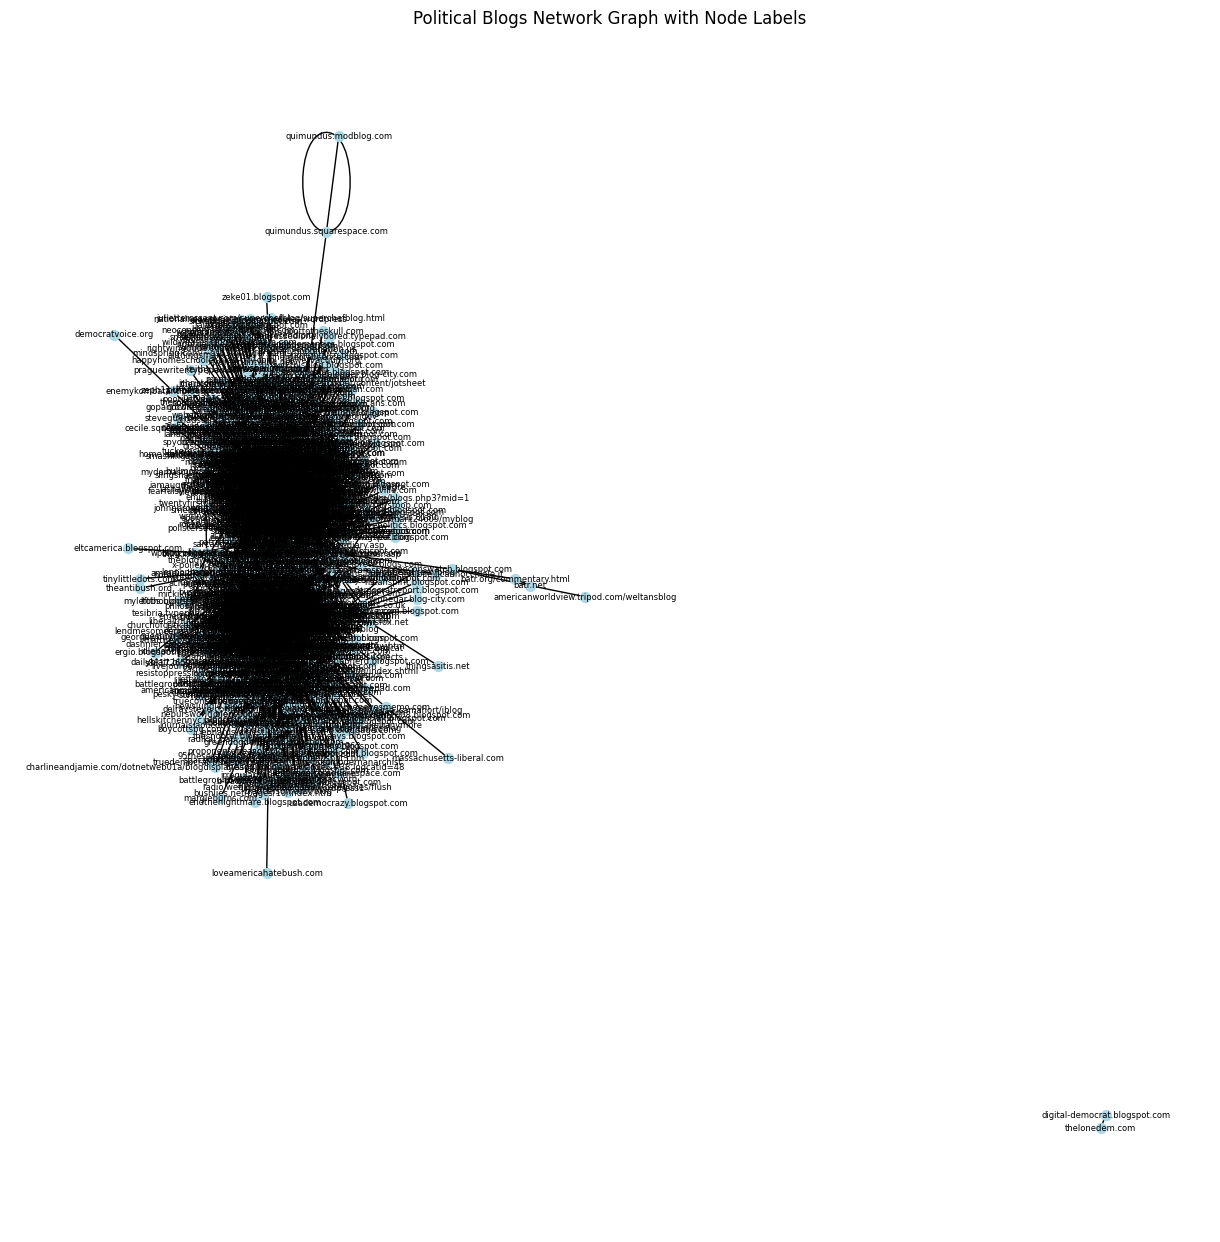

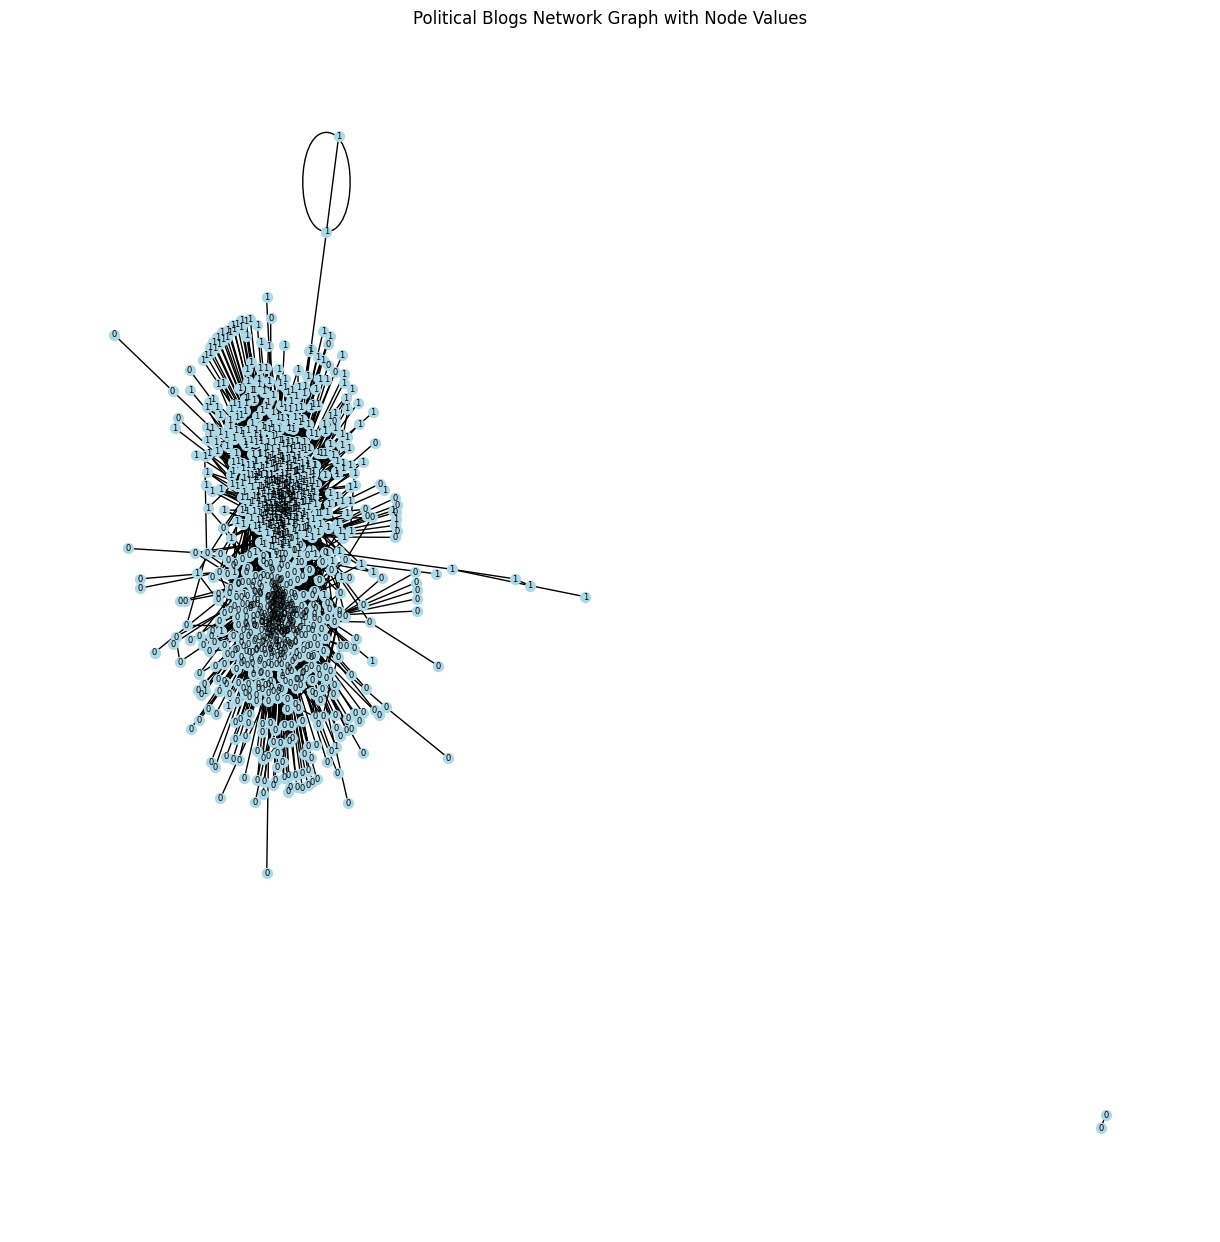

In [33]:
POLITICAL_BLOGS_DATASET_DIR = './data/polblogs'
POLITICAL_BLOGS_DATASET_NAME = 'Political Blogs'

G_blogs = extract_graph(POLITICAL_BLOGS_DATASET_DIR, nodes_properties=['index', 'label', 'source', 'value', '_pos'])
print_graph_metrics(G_blogs, POLITICAL_BLOGS_DATASET_NAME, font_size=6, node_size=50, seed=1)

In [31]:
def plot_nodes_value_distribution(G, value_mapping):
    node_values = [value_mapping.get(G.nodes[node]['value'], G.nodes[node]['value']) for node in G.nodes]

    # Count the occurrences of each label
    value_counts = pd.Series(node_values).value_counts()

    # Plot the value counts as a bar plot
    plt.figure(figsize=(10, 6))
    value_counts.plot(kind='bar', color='lightblue')
    plt.title('Number of Nodes for Each Value')
    plt.xlabel('Value')
    plt.ylabel('Number of Nodes')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.show()

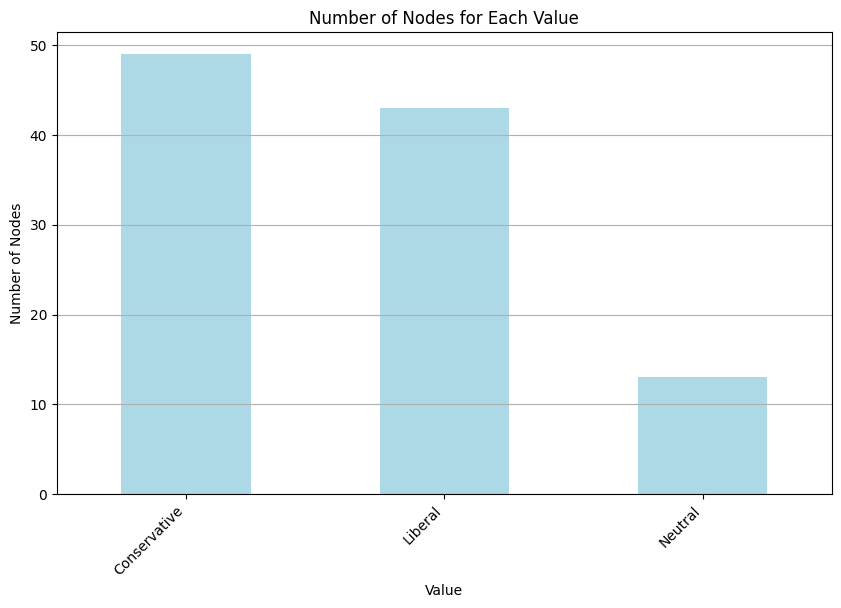

In [32]:
BOOKS_VALUE_MAPPING = {'l': 'Liberal', 'n': 'Neutral', 'c': 'Conservative'}
plot_nodes_value_distribution(G_books, BOOKS_VALUE_MAPPING)

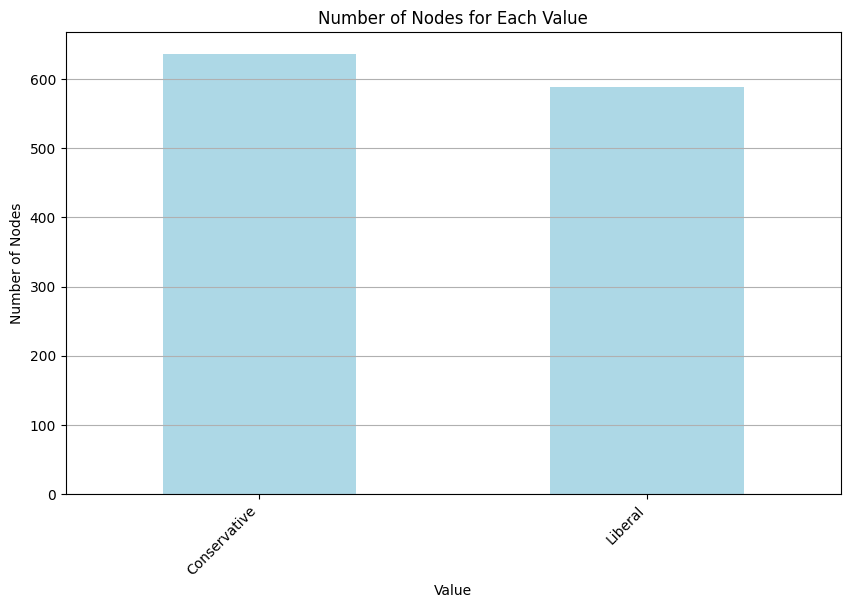

In [35]:
BLOGS_VALUE_MAPPING = {0: 'Liberal', 1: 'Conservative'}
plot_nodes_value_distribution(G_blogs, BLOGS_VALUE_MAPPING)

## PageRank

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_page_rank(G, pagerank, num_rows_to_show=50, dataset_name='Book'):
    titles = [G.nodes[node].get('label', '') for node in G.nodes]  # Get 'label' attribute or node ID
    pagerank_values = [pagerank[node] for node in G.nodes]
    political_labels = [G.nodes[node].get('value', '') for node in G.nodes]  # Get 'value' for political label

    # Create a DataFrame for easy handling
    df_pagerank = pd.DataFrame({
        f'{dataset_name} Title': titles,
        'PageRank': pagerank_values,
        'Political Label': political_labels
    })

    # Sort the DataFrame by PageRank values (highest to lowest)
    df_pagerank_sorted = df_pagerank.sort_values(by='PageRank', ascending=False)[:num_rows_to_show]

    # Plotting the PageRank values with political labels
    plt.figure(figsize=(14, 20))  # Increase figure size for more space
    bars = plt.barh(df_pagerank_sorted[f'{dataset_name} Title'], df_pagerank_sorted['PageRank'], color='skyblue', height=0.8)

    # Annotate each bar with the political label
    for i, bar in enumerate(bars):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
                df_pagerank_sorted['Political Label'].iloc[i], 
                va='center', ha='left', fontsize=10, color='black')

    plt.title(f'Top {num_rows_to_show} PageRank of {dataset_name}s with Political Labels')
    plt.xlabel('PageRank Value')
    plt.ylabel(f'{dataset_name} Title')
    plt.gca().invert_yaxis()
    plt.tight_layout()

    # Plot the distribution of PageRank values
    plt.figure(figsize=(10, 6))
    plt.hist(pagerank_values, bins=50, color='lightgreen', edgecolor='black', alpha=0.75)
    plt.title(f'Distribution of PageRank Values for {dataset_name}s')
    plt.xlabel('PageRank Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()

    plt.show()
    
    pd.set_option('display.max_rows', None)
    return df_pagerank_sorted


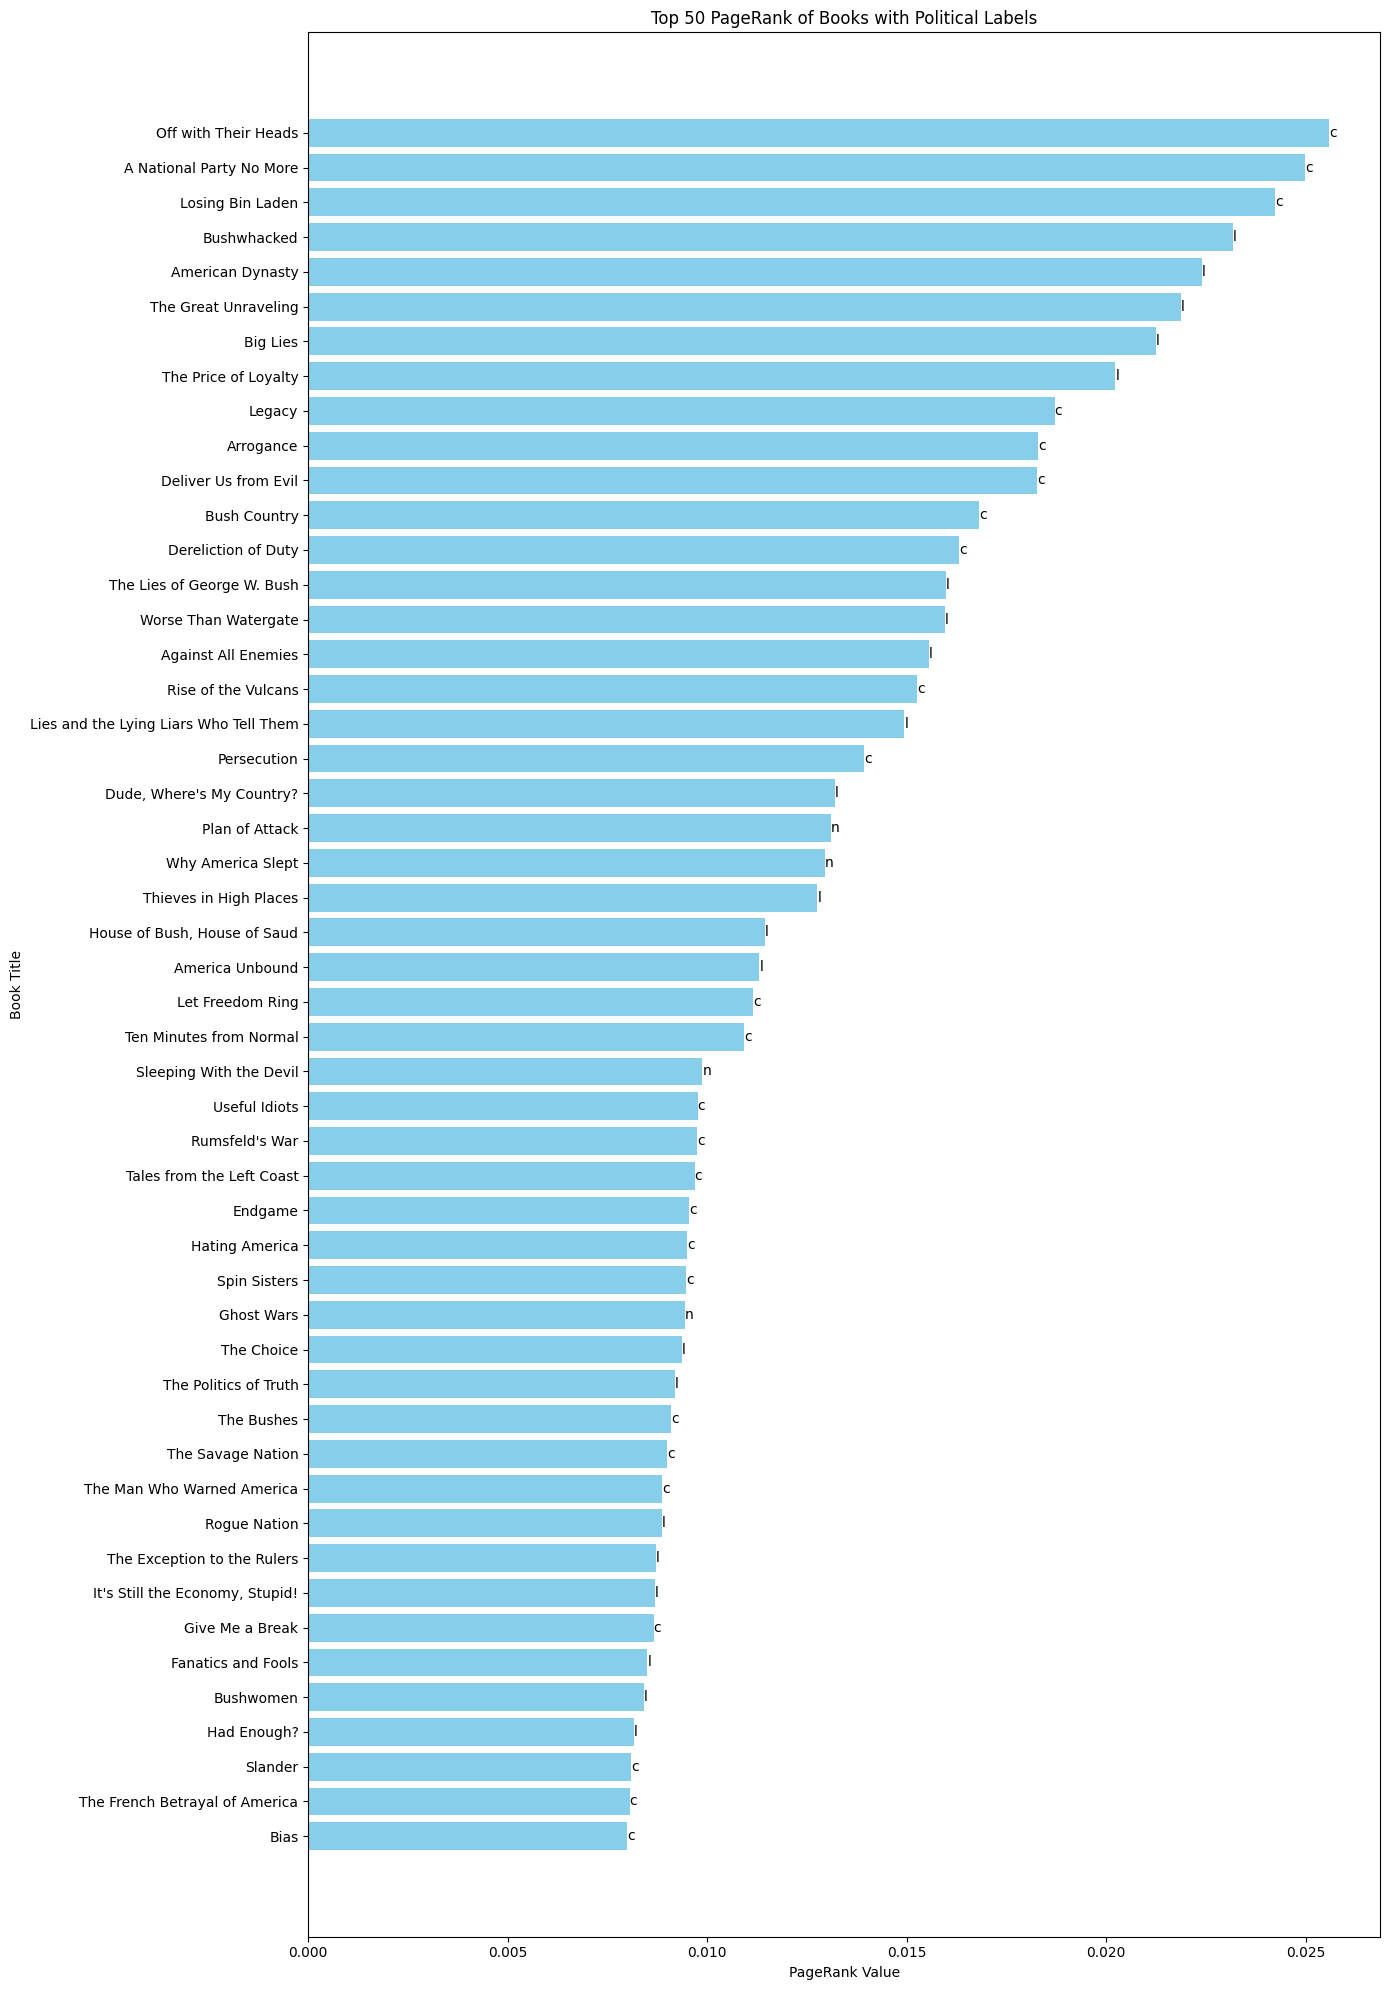

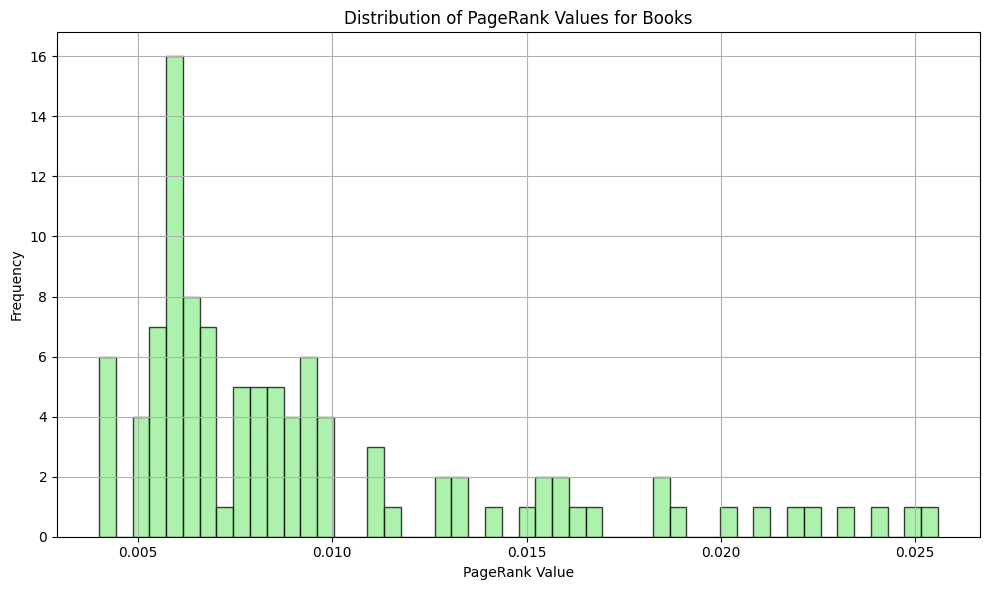

Book Title  PageRank Political Label
12                     Off with Their Heads  0.025587               c
8                  A National Party No More  0.024990               c
3                          Losing Bin Laden  0.024230               c
84                              Bushwhacked  0.023180               l
72                         American Dynasty  0.022393               l
66                     The Great Unraveling  0.021868               l
73                                 Big Lies  0.021253               l
30                     The Price of Loyalty  0.020231               l
11                                   Legacy  0.018712               c
47                                Arrogance  0.018305               c
40                     Deliver Us from Evil  0.018267               c
9                              Bush Country  0.016811               c
10                      Dereliction of Duty  0.016323               c
74               The Lies of George W. Bush  0.015985               l
75                     Worse Than Watergate  0.015954               l
71                      Against All Enemies  0.015559               l
58                      Rise of the Vulcans  0.015260               c
86   Lies and the Lying Liars Who Tell Them  0.014946               l
13                              Persecution  0.013943               c
99                Dude, Where's My Country?  0.013204               l
76                           Plan of Attack  0.013109               n
6                         Why America Slept  0.012958               n
100                  Thieves in High Places  0.012763               l
31             House of Bush, House of Saud  0.011447               l
64                          America Unbound  0.011310               l
34                         Let Freedom Ring  0.011160               c
20                  Ten Minutes from Normal  0.010924               c
4                   Sleeping With the Devil  0.009884               n
33                            Useful Idiots  0.009764               c
14                           Rumsfeld's War  0.009759               c
23                Tales from the Left Coast  0.009686               c
26                                  Endgame  0.009548               c
24                           Hating America  0.009492               c
27                             Spin Sisters  0.009468               c
7                                Ghost Wars  0.009447               n
65                               The Choice  0.009373               l
82                    The Politics of Truth  0.009190               l
49                               The Bushes  0.009104               c
39                        The Savage Nation  0.008999               c
5                The Man Who Warned America  0.008865               c
67                             Rogue Nation  0.008858               l
91              The Exception to the Rulers  0.008707               l
94          It's Still the Economy, Stupid!  0.008690               l
41                          Give Me a Break  0.008657               c
83                       Fanatics and Fools  0.008501               l
79                                Bushwomen  0.008417               l
93                              Had Enough?  0.008170               l
38                                  Slander  0.008096               c
22           The French Betrayal of America  0.008059               c
37                                     Bias  0.007996               c

In [21]:
books_pagerank = nx.pagerank(G_books)
plot_page_rank(G_books, books_pagerank)

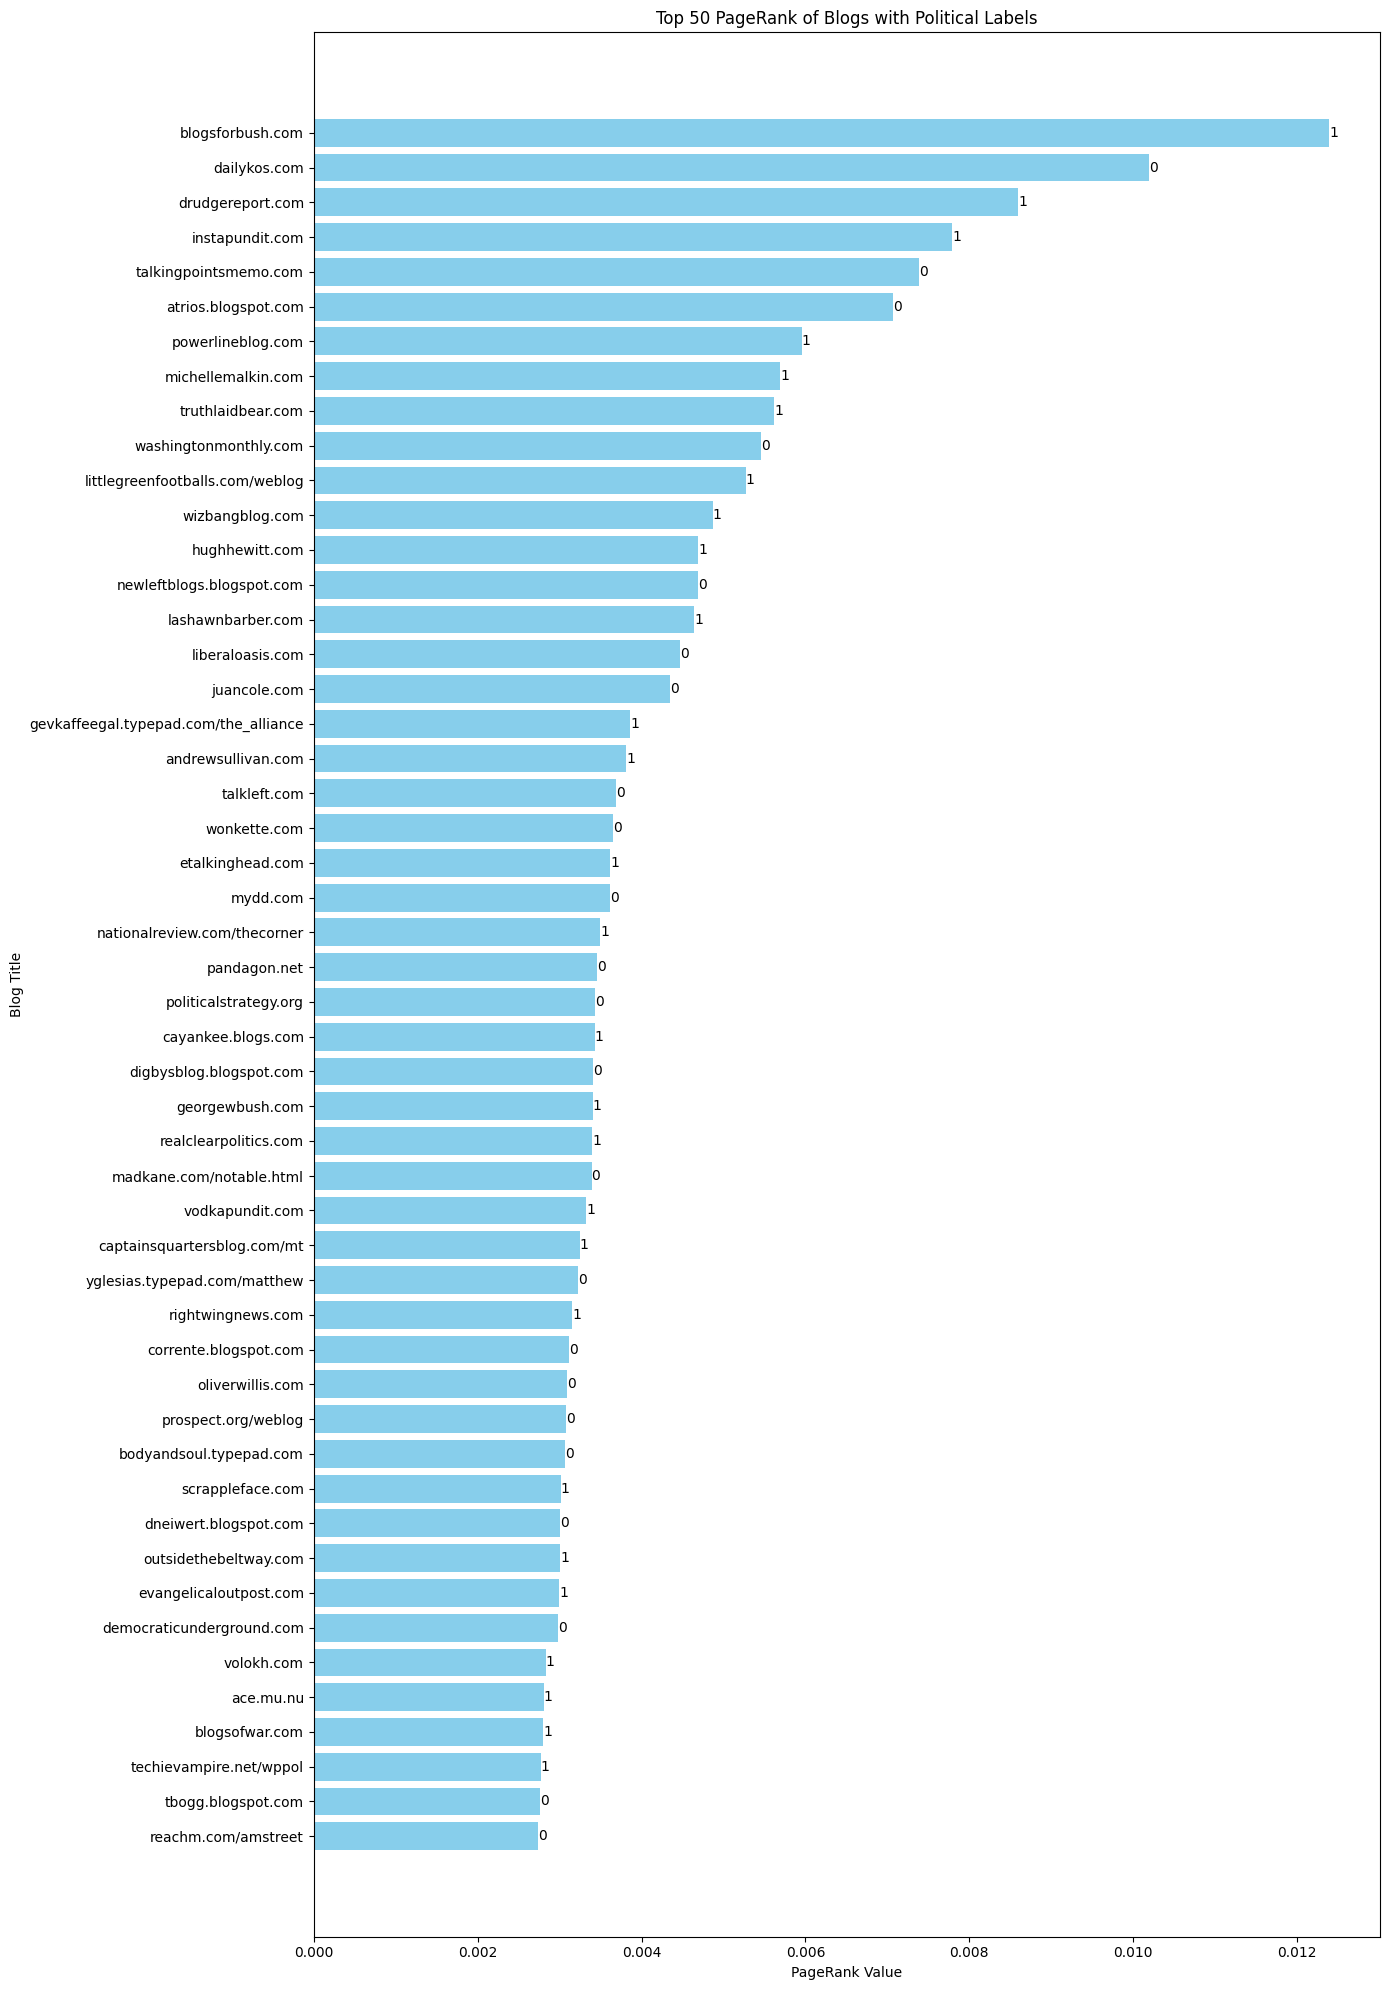

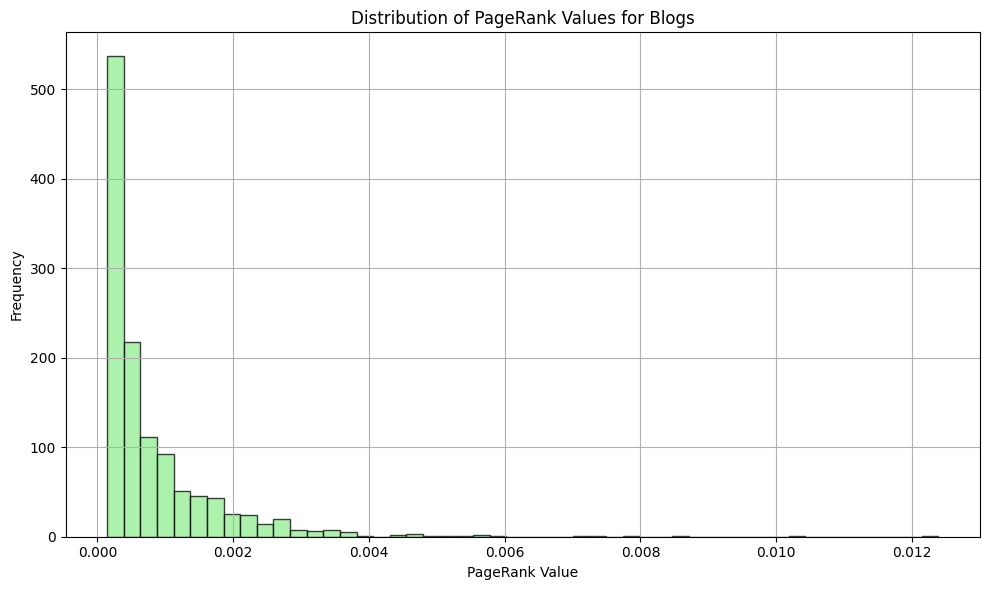

Blog Title  PageRank  Political Label
301                       blogsforbush.com  0.012391                1
11                            dailykos.com  0.010188                0
179                       drudgereport.com  0.008594                1
100                        instapundit.com  0.007789                1
15                   talkingpointsmemo.com  0.007387                0
13                     atrios.blogspot.com  0.007069                0
5                        powerlineblog.com  0.005954                1
169                     michellemalkin.com  0.005693                1
54                       truthlaidbear.com  0.005621                1
93                   washingtonmonthly.com  0.005460                0
223        littlegreenfootballs.com/weblog  0.005271                1
123                        wizbangblog.com  0.004870                1
125                         hughhewitt.com  0.004694                1
95               newleftblogs.blogspot.com  0.004688                0
536                      lashawnbarber.com  0.004645                1
36                        liberaloasis.com  0.004469                0
12                            juancole.com  0.004349                0
444  gevkaffeegal.typepad.com/the_alliance  0.003860                1
126                     andrewsullivan.com  0.003814                1
8                             talkleft.com  0.003694                0
75                            wonkette.com  0.003648                0
162                       etalkinghead.com  0.003620                1
7                                 mydd.com  0.003611                0
124           nationalreview.com/thecorner  0.003496                1
105                           pandagon.net  0.003460                0
66                   politicalstrategy.org  0.003429                0
659                     cayankee.blogs.com  0.003426                1
32                 digbysblog.blogspot.com  0.003408                0
76                         georgewbush.com  0.003404                1
197                  realclearpolitics.com  0.003399                1
58                madkane.com/notable.html  0.003391                0
114                        vodkapundit.com  0.003323                1
402            captainsquartersblog.com/mt  0.003246                1
39            yglesias.typepad.com/matthew  0.003229                0
461                      rightwingnews.com  0.003153                1
26                   corrente.blogspot.com  0.003118                0
6                         oliverwillis.com  0.003090                0
78                     prospect.org/weblog  0.003078                0
25                 bodyandsoul.typepad.com  0.003066                0
367                       scrappleface.com  0.003015                1
120                  dneiwert.blogspot.com  0.003008                0
167                  outsidethebeltway.com  0.003007                1
677                 evangelicaloutpost.com  0.002995                1
185              democraticunderground.com  0.002978                0
220                             volokh.com  0.002830                1
735                              ace.mu.nu  0.002808                1
337                         blogsofwar.com  0.002797                1
829                techievampire.net/wppol  0.002768                1
3                       tbogg.blogspot.com  0.002763                0
24                     reachm.com/amstreet  0.002736                0

In [22]:
blogs_pagerank = nx.pagerank(G_blogs)
plot_page_rank(G_blogs, blogs_pagerank, dataset_name='Blog')

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib as mpl

# Function to plot the graph with different text labels and PageRank-based coloring
def plot_graph_with_labels(G, pagerank, label_type='index'):
    """
    Plot the graph with nodes colored by PageRank and labeled by the chosen type.

    Parameters:
    - G: The NetworkX graph
    - pagerank: The PageRank values of the nodes
    - label_type: The type of label ('index', 'label', or 'value')
    """
    # Extract node information
    node_indices = list(G.nodes)  # Node indices
    node_labels = [G.nodes[node].get('label', '') for node in G.nodes]  # Using 'label' attribute
    node_values = [G.nodes[node].get('value', '') for node in G.nodes]  # Using 'value' attribute

    # Format the node text based on the chosen label type
    if label_type == 'index':
        node_texts = [node for node in node_indices]
    elif label_type == 'label':
        node_texts = [label for label in node_labels]
    elif label_type == 'value':
        node_texts = [value for value in node_values]
    else:
        raise ValueError("Invalid label_type. Choose from 'index', 'label', or 'value'.")

    # Define colormap for coloring based on PageRank
    cmap = plt.cm.viridis

    # Create a figure for plotting
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Node colors based on PageRank
    node_colors = [pagerank[node] for node in G.nodes]

    pos = nx.spring_layout(G, seed=42)  # Use a consistent layout
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=cmap, node_size=500, ax=ax)
    nx.draw_networkx_edges(G, pos, ax=ax)
    nx.draw_networkx_labels(G, pos, labels={node: text for node, text in zip(G.nodes, node_texts)}, font_size=10, ax=ax)

    # Title and axis settings
    ax.set_title(f'Graph with PageRank-based Coloring and {label_type.capitalize()} Labels')
    ax.axis('off')  # Hide the axis
    
    # Add colorbar for PageRank
    norm = mpl.colors.Normalize(vmin=min(pagerank.values()), vmax=max(pagerank.values()))
    cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax, orientation='vertical')
    cbar.set_label('PageRank')

    # Show the plot
    plt.tight_layout()
    plt.show()

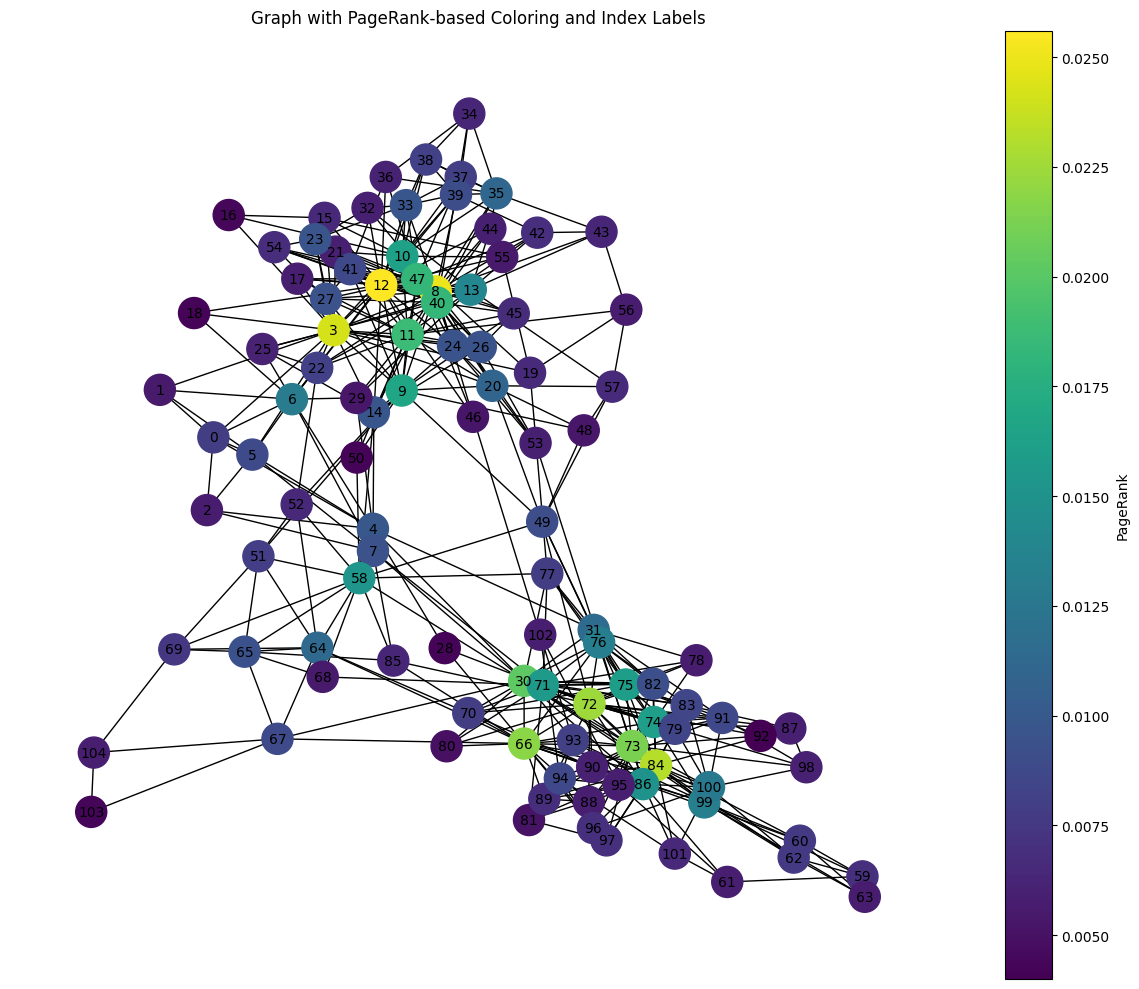

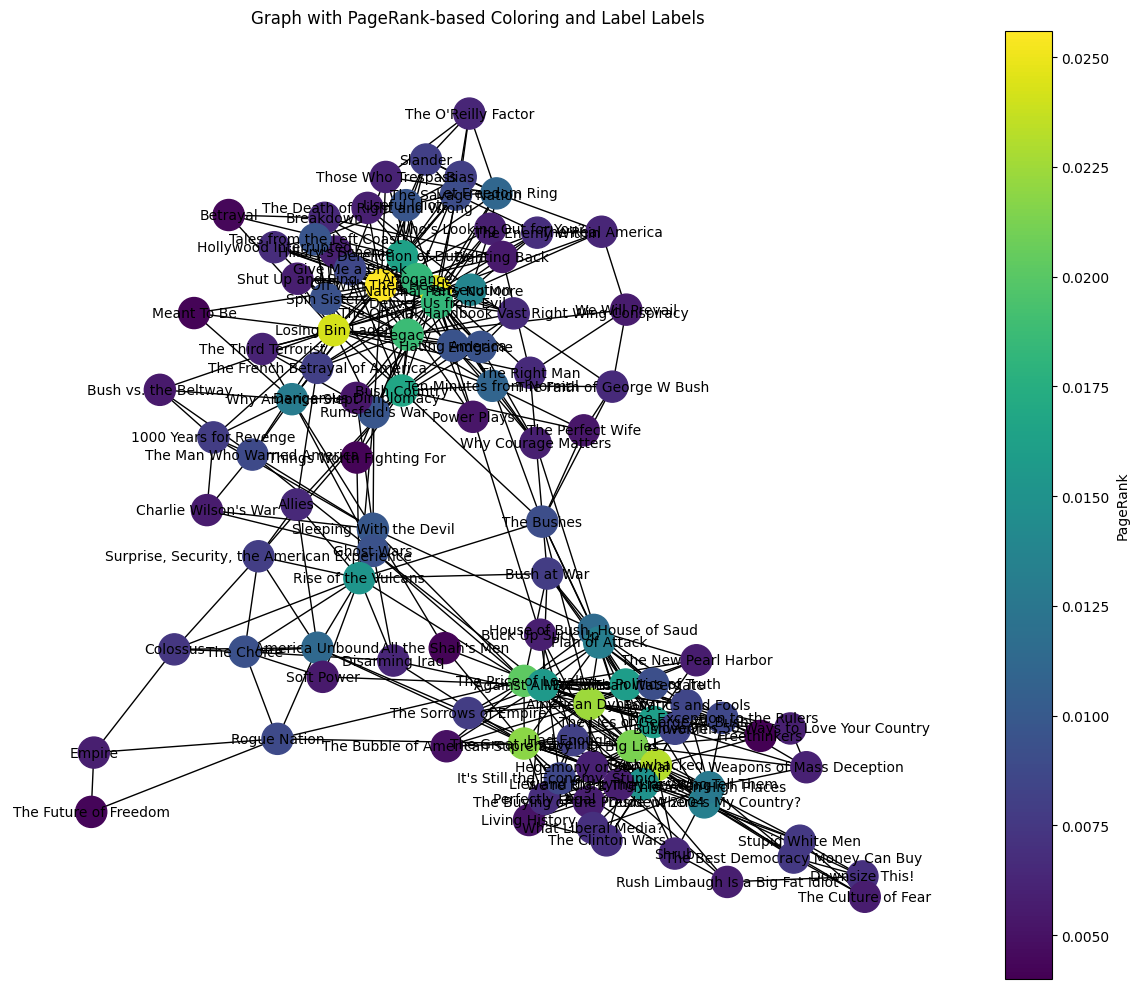

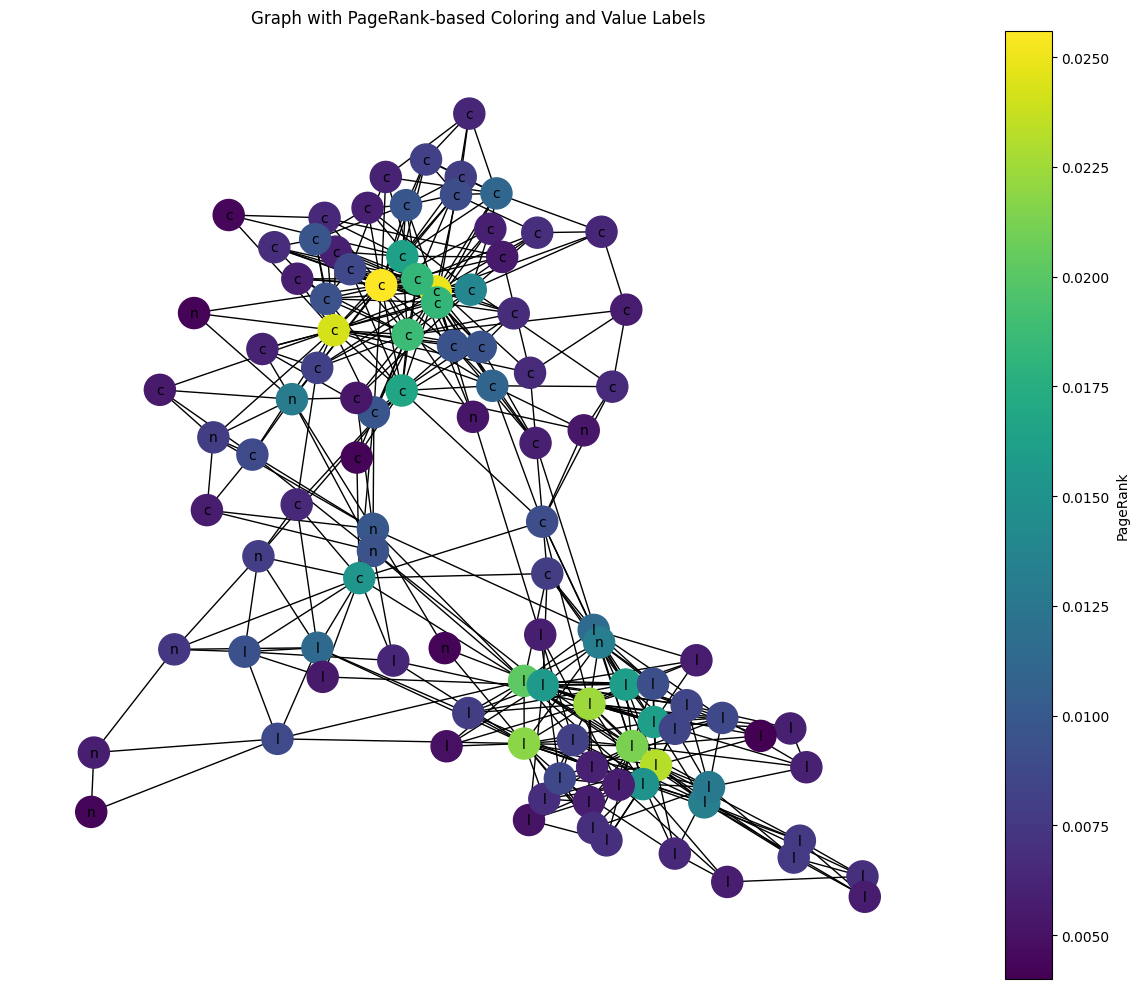

In [43]:
plot_graph_with_labels(G_books, books_pagerank, label_type='index')   # Plot with index
plot_graph_with_labels(G_books, books_pagerank, label_type='label')   # Plot with label
plot_graph_with_labels(G_books, books_pagerank, label_type='value')   # Plot with value

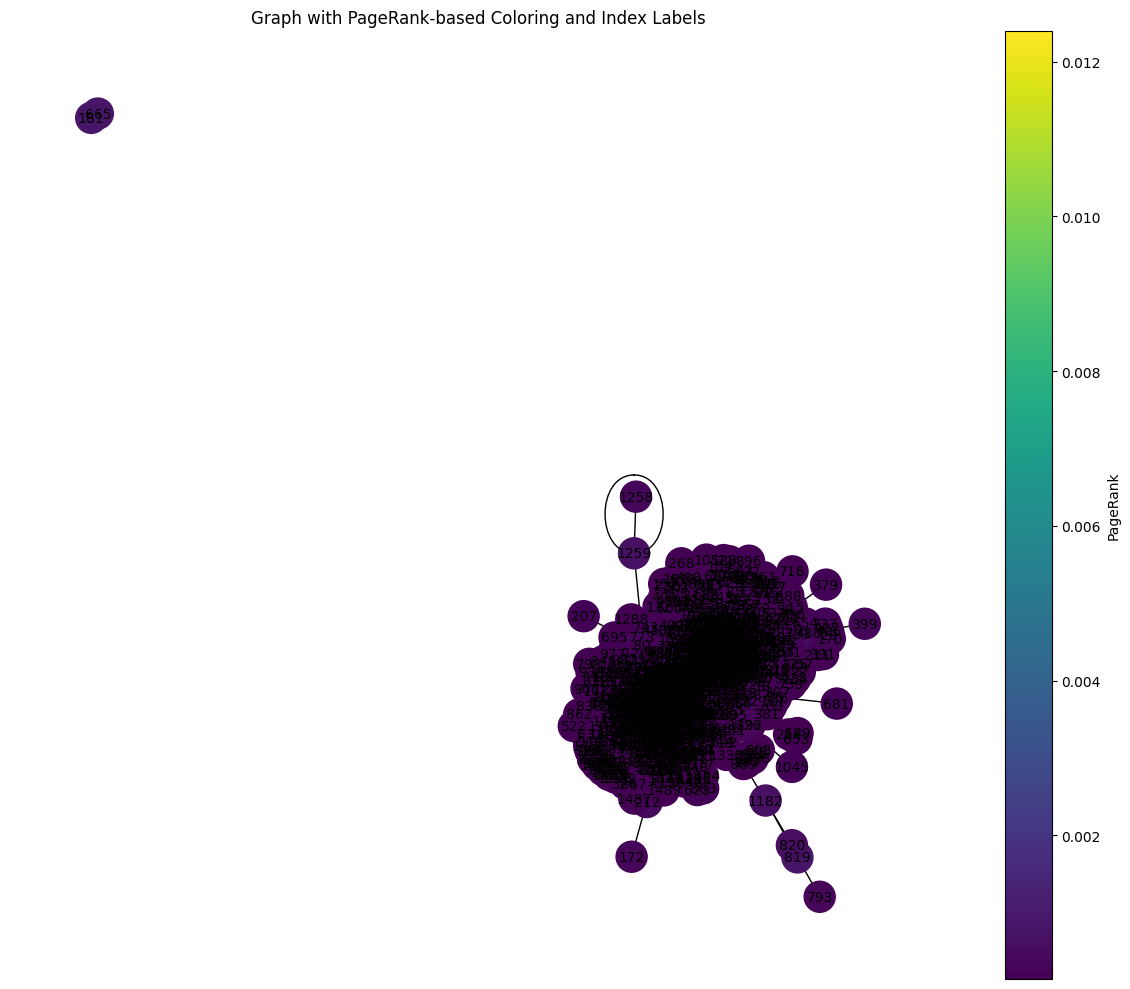

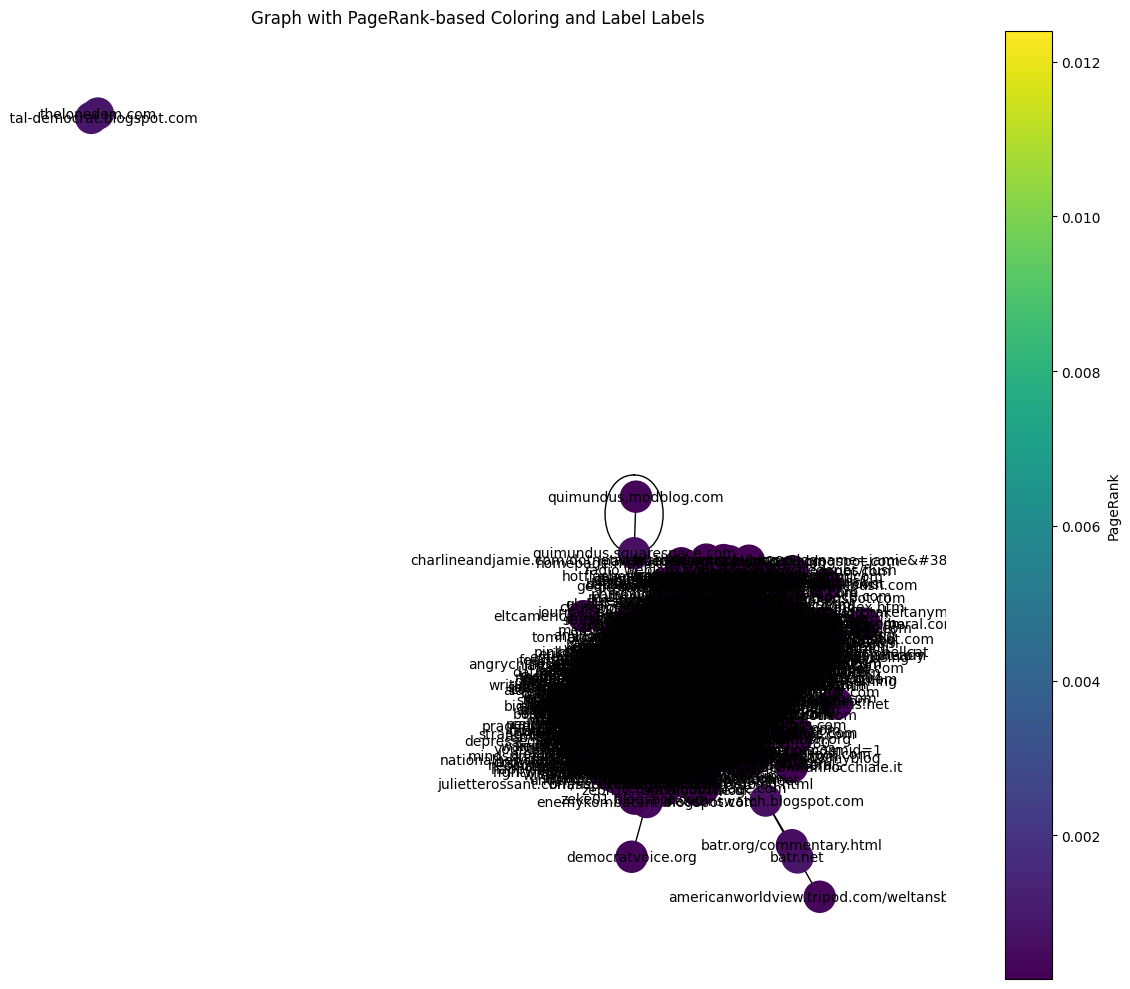

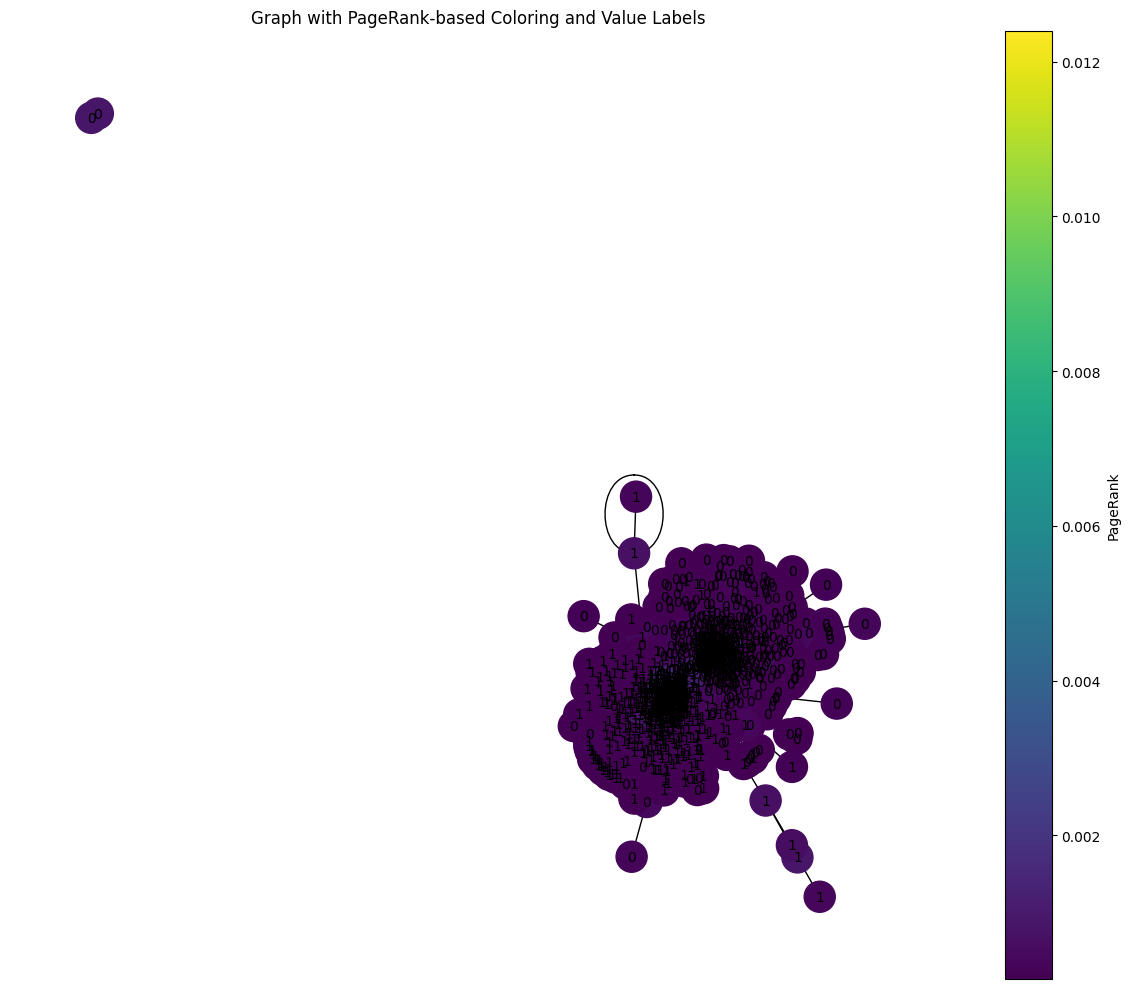

In [44]:
plot_graph_with_labels(G_blogs, blogs_pagerank, label_type='index')   # Plot with index
plot_graph_with_labels(G_blogs, blogs_pagerank, label_type='label')   # Plot with label
plot_graph_with_labels(G_blogs, blogs_pagerank, label_type='value')   # Plot with value

## k-Core Decomposition

In [30]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

def plot_k_core_graph(G, k_core, node_attr, figsize=(10, 10), seed=42):
    """
    Plots a network graph with node colors representing k-core values.

    Args:
        G: NetworkX graph object.
        k_core: Dictionary containing k-core values for each node in the graph.
        node_attr: String specifying the node attribute to use for labels ('index', 'label', or 'value').
        figsize: Tuple specifying the figure size.
        seed: Seed for the spring layout.

    Returns:
        None
    """

    fig, ax = plt.subplots(figsize=figsize)

    # Create the spring layout for the graph
    pos = nx.spring_layout(G, seed=seed)

    # Set node colors based on k-core values
    node_colors = [k_core[node] for node in G.nodes]

    # Draw the graph with node colors based on k-core values
    nodes = nx.draw_networkx_nodes(
        G, pos, node_color=node_colors, cmap=plt.cm.viridis, node_size=500, ax=ax
    )
    nx.draw_networkx_edges(G, pos, ax=ax)

    # Determine labels based on node_attr
    if node_attr == 'index':
        labels = {node: str(node) for node in G.nodes}
    elif node_attr == 'label':
        labels = {node: G.nodes[node].get('label', '') for node in G.nodes}
    elif node_attr == 'value':
        labels = {node: str(G.nodes[node].get('value', '')) for node in G.nodes}
    else:
        raise ValueError("Invalid node_attr. Choose 'index', 'label', or 'value'.")

    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, ax=ax)

    # Create a ScalarMappable object
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    sm.set_array([])  # Set an empty array for the ScalarMappable

    # Add a color bar with a separate axis
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
    cbar.set_label('k-core value')

    # Set the limits of the colormap and force integer ticks
    cbar.mappable.set_clim(vmin=int(min(node_colors)), vmax=int(max(node_colors)))
    cbar.set_ticks(np.arange(int(min(node_colors)), int(max(node_colors)) + 1))

    # Final touches
    ax.set_title(f"Network Graph with k-core Coloring (Node Labels: {node_attr})")
    ax.axis('off')  # Turn off axis for the graph
    plt.show()


def plot_k_core_graph_metrics(G):
    k_core = nx.core_number(G)

    max_k = max(k_core.values())
    min_k = min(k_core.values())
    for i in range(min_k, max_k+1):
        print(f'Num of nodes with core number {i}: {len([number for number in k_core.values() if number == i])}')
    
    # Plot the k-core graph with different node attributes as labels
    plot_k_core_graph(G, k_core, 'index')  # Plot with node indices as labels
    plot_k_core_graph(G, k_core, 'label')  # Plot with node labels as labels
    plot_k_core_graph(G, k_core, 'value')  # Plot with node values as labels
    
    # Plot the distribution of k-core values
    plt.figure(figsize=(10, 6))
    k_core_values = list(k_core.values())
    plt.hist(k_core_values, bins=range(min(k_core_values), max(k_core_values) + 1), color='blue', edgecolor='black', alpha=0.8)
    plt.title('Distribution of k-core Values')
    plt.xlabel('k-core Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Create a DataFrame for the summary of k-core values
    summary_df = pd.DataFrame({
        'index': list(G.nodes),
        'k_core_value': [k_core[node] for node in G.nodes],
        'label': [G.nodes[node].get('label', '') for node in G.nodes],
        'value': [G.nodes[node].get('value', None) for node in G.nodes]
    })

    # Display the DataFrame
    return summary_df


Num of nodes with core number 2: 2
Num of nodes with core number 3: 5
Num of nodes with core number 4: 33
Num of nodes with core number 5: 25
Num of nodes with core number 6: 40


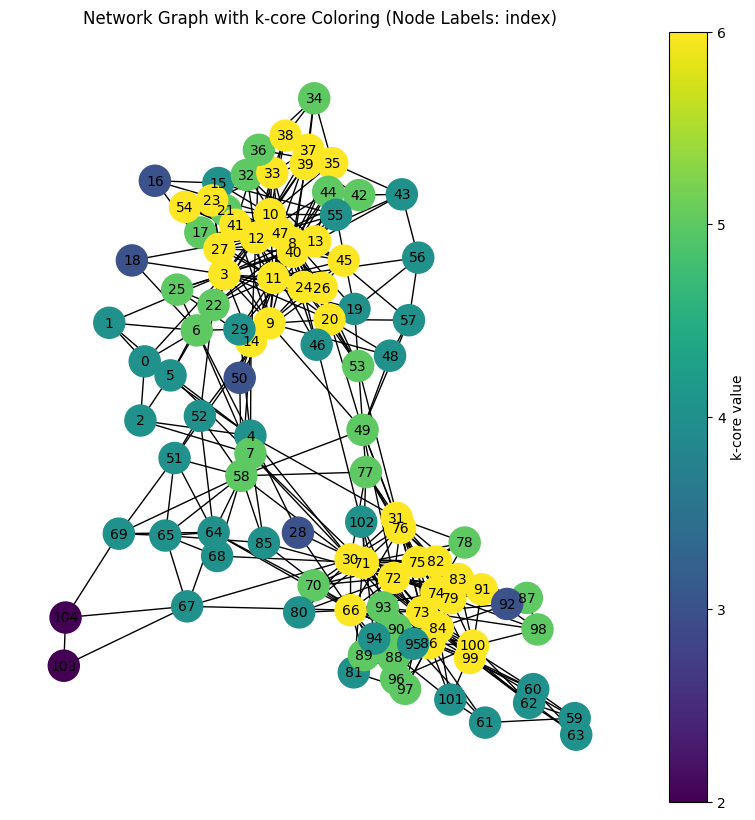

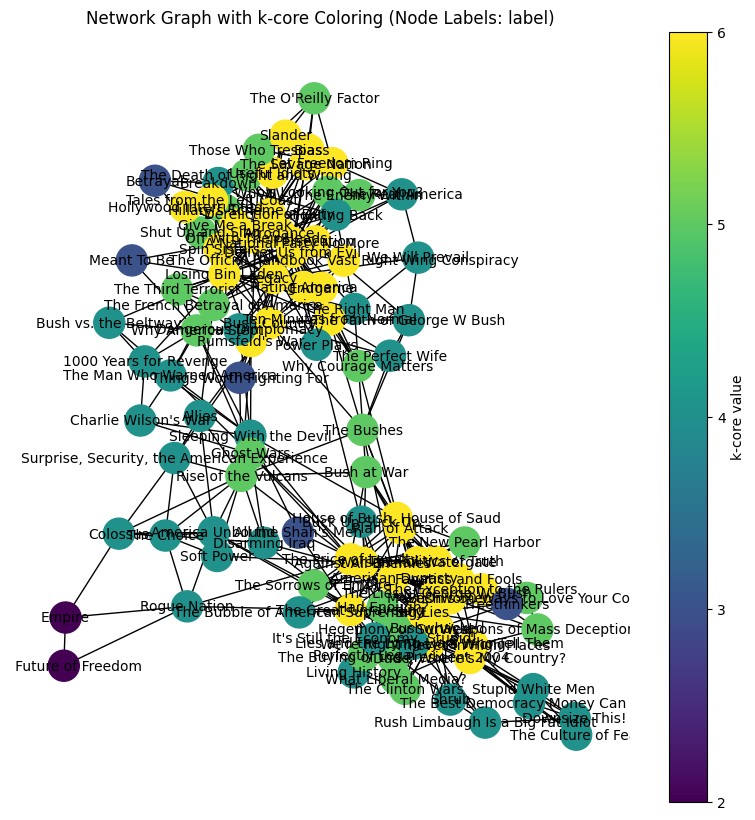

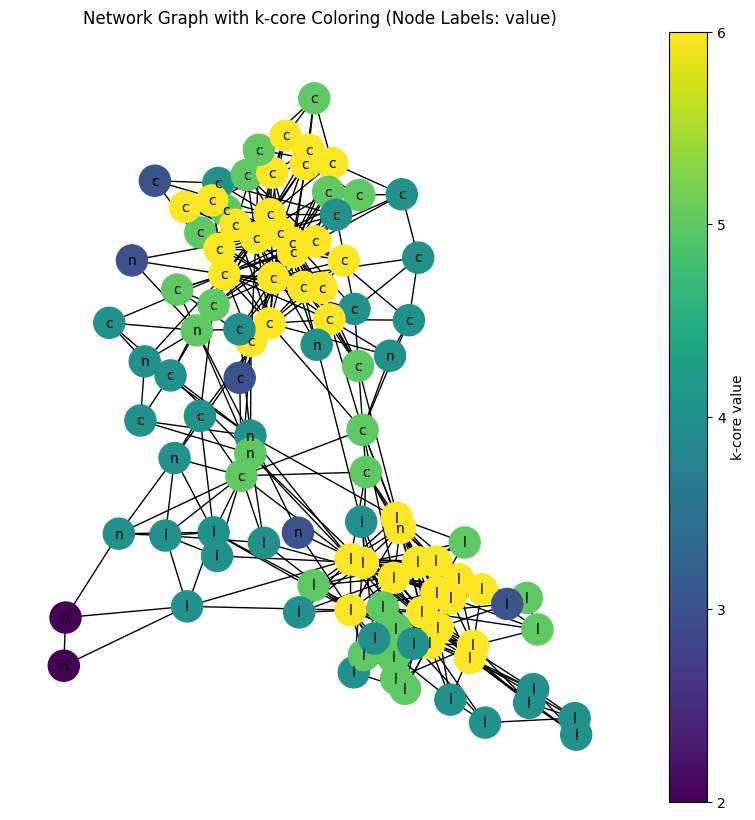

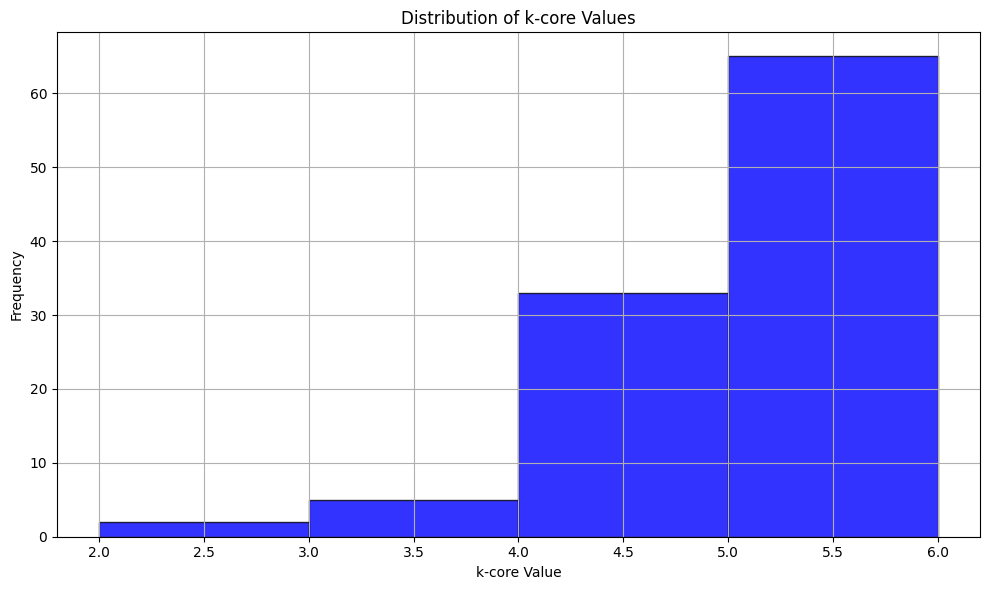

index  k_core_value                                             label  \
0        1             4                              Bush vs. the Beltway   
1        0             4                            1000 Years for Revenge   
2        2             4                              Charlie Wilson's War   
3        3             6                                  Losing Bin Laden   
4        4             4                           Sleeping With the Devil   
5        5             4                        The Man Who Warned America   
6        6             5                                 Why America Slept   
7        7             5                                        Ghost Wars   
8        8             6                          A National Party No More   
9        9             6                                      Bush Country   
10      10             6                               Dereliction of Duty   
11      11             6                                            Legacy   
12      12             6                              Off with Their Heads   
13      13             6                                       Persecution   
14      14             6                                    Rumsfeld's War   
15      15             4                                         Breakdown   
16      16             3                                          Betrayal   
17      17             5                                  Shut Up and Sing   
18      18             3                                       Meant To Be   
19      19             4                                     The Right Man   
20      20             6                           Ten Minutes from Normal   
21      21             5                                  Hillary's Scheme   
22      22             5                    The French Betrayal of America   
23      23             6                         Tales from the Left Coast   
24      24             6                                    Hating America   
25      25             5                               The Third Terrorist   
26      26             6                                           Endgame   
27      27             6                                      Spin Sisters   
28      28             3                                All the Shah's Men   
29      29             4                              Dangerous Dimplomacy   
30      30             6                              The Price of Loyalty   
31      31             6                      House of Bush, House of Saud   
32      32             5                      The Death of Right and Wrong   
33      33             6                                     Useful Idiots   
34      35             6                                  Let Freedom Ring   
35      34             5                               The O'Reilly Factor   
36      36             5                                Those Who Trespass   
37      37             6                                              Bias   
38      38             6                                           Slander   
39      39             6                                 The Savage Nation   
40      40             6                              Deliver Us from Evil   
41      41             6                                   Give Me a Break   
42      42             5                                  The Enemy Within   
43      43             4                                  The Real America   
44      44             5                        Who's Looking Out for You?   
45      45             6  The Official Handbook Vast Right Wing Conspiracy   
46      46             4                                       Power Plays   
47      47             6                                         Arrogance   
48      48             4                                  The Perfect Wife   
49      49             5                                        The Bushes   
50      50             3   

In [26]:
plot_k_core_graph_metrics(G_books)

Num of nodes with core number 1: 140
Num of nodes with core number 2: 111
Num of nodes with core number 3: 79
Num of nodes with core number 4: 45
Num of nodes with core number 5: 47
Num of nodes with core number 6: 46
Num of nodes with core number 7: 31
Num of nodes with core number 8: 30
Num of nodes with core number 9: 19
Num of nodes with core number 10: 18
Num of nodes with core number 11: 35
Num of nodes with core number 12: 25
Num of nodes with core number 13: 25
Num of nodes with core number 14: 32
Num of nodes with core number 15: 24
Num of nodes with core number 16: 28
Num of nodes with core number 17: 30
Num of nodes with core number 18: 21
Num of nodes with core number 19: 13
Num of nodes with core number 20: 14
Num of nodes with core number 21: 14
Num of nodes with core number 22: 17
Num of nodes with core number 23: 19
Num of nodes with core number 24: 18
Num of nodes with core number 25: 24
Num of nodes with core number 26: 18
Num of nodes with core number 27: 8
Num of no

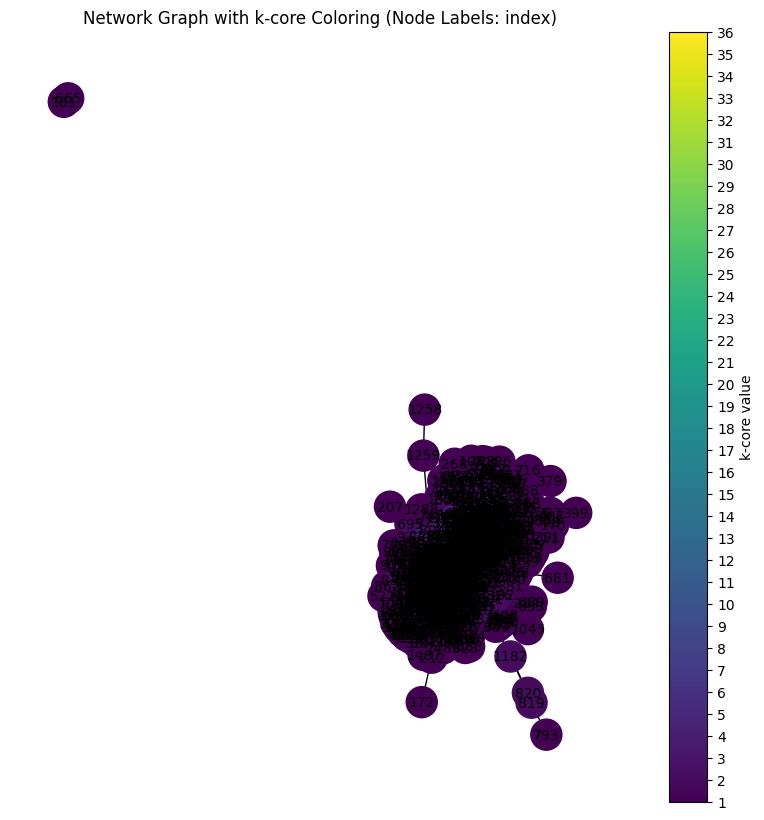

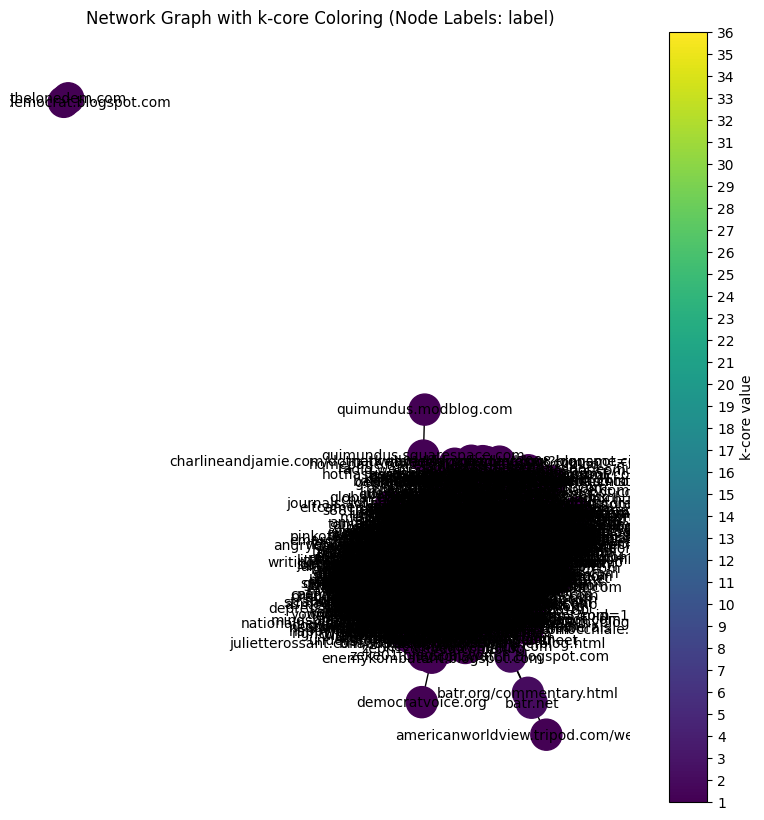

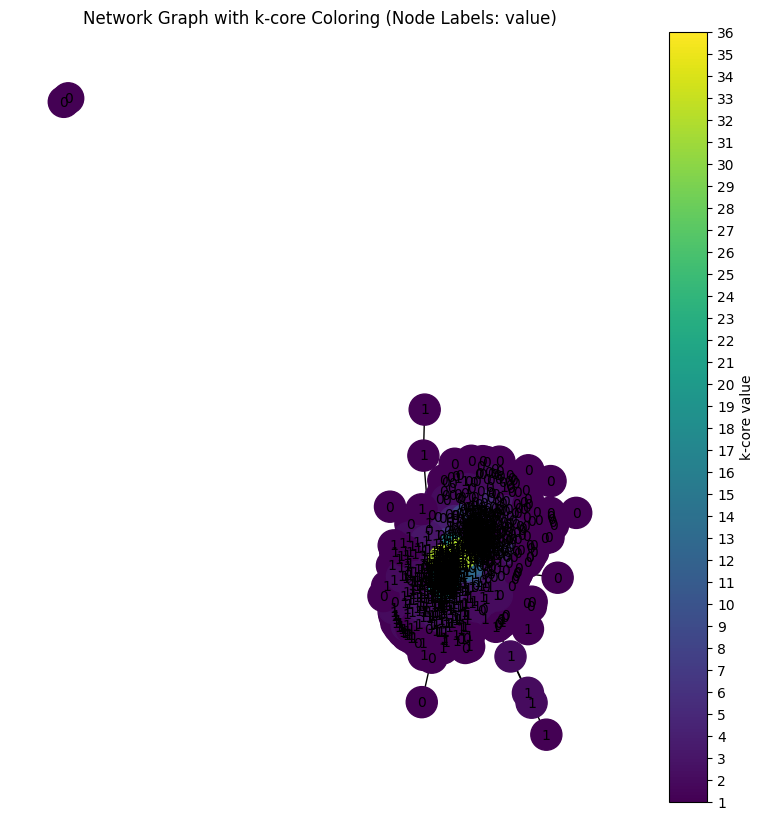

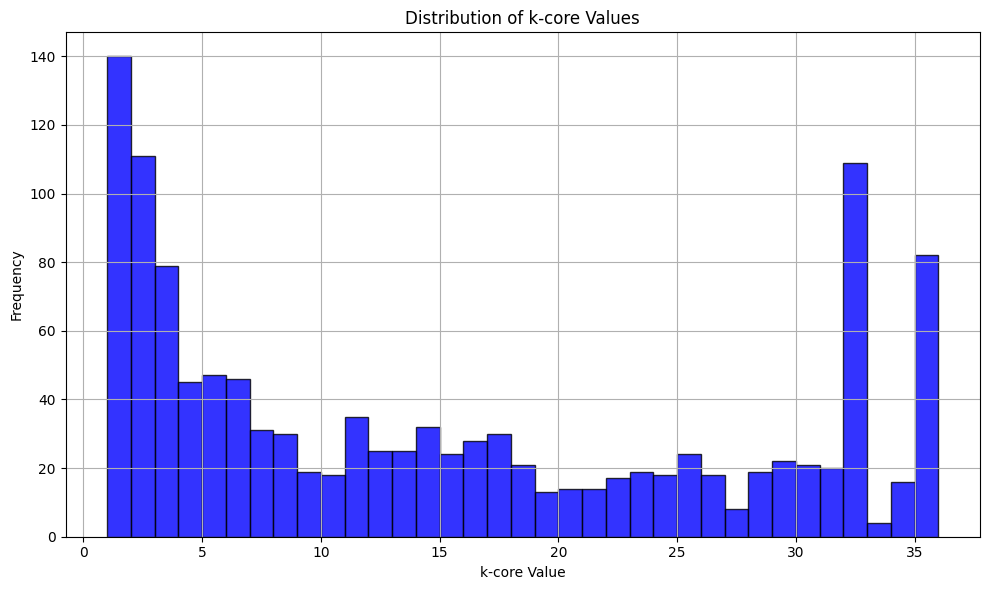

index  k_core_value                                              label  \
0         0            22                               100monkeystyping.com   
1       574            31                            rudepundit.blogspot.com   
2      1434            27                                  townhall.com/clog   
3       643            36                                 tbogg.blogspot.com   
4        22            34                           americablog.blogspot.com   
5      1244            32                                  powerlineblog.com   
6       482            36                                   oliverwillis.com   
7       433            36                                           mydd.com   
8       641            36                                       talkleft.com   
9       366             7                             lightupthedarkness.org   
10       84            32                                 blogforamerica.com   
11      154            36                                       dailykos.com   
12      322            36                                       juancole.com   
13       54            36                                atrios.blogspot.com   
14      663            36                                 theleftcoaster.com   
15      640            36                              talkingpointsmemo.com   
16        1            31                         12thharmonic.com/wordpress   
17       28            29                                amleft.blogspot.com   
18      445            29                                     needlenose.com   
19      543            18                       raedinthemiddle.blogspot.com   
20      563            31                         riverbendblog.blogspot.com   
21       17            31                           allspinzone.blogspot.com   
22      430            35                           msnbc.msn.com/id/3449870   
23       23            32                                    americablog.org   
24      546            36                                reachm.com/amstreet   
25       98            36                            bodyandsoul.typepad.com   
26      143            36                              corrente.blogspot.com   
27      153            35                                    dailyhowler.com   
28      158            24                                    davidsirota.com   
29      203            30                                     electablog.com   
30      247            26                                     gregpalast.com   
31      649            35                                    the-hamster.com   
32      179            36                            digbysblog.blogspot.com   
33      494            35                            patriotboy.blogspot.com   
34      331            22                                        kensain.com   
35      171            36                                 democrats.org/blog   
36      362            36                                   liberaloasis.com   
37      388            35                                       mahablog.com   
38      390            25                      margaretcho.com/blog/blog.htm   
39      755            36                       yglesias.typepad.com/matthew   
40      237            34                                  gisleson.com/blog   
41      476            32                            obsidianwings.blogs.com   
42      668            36                                     thepoorman.net   
43      560            35                        rising-hegemon.blogspot.com   
44      562            36                           rittenhouse.blogspot.com   
45      565            36                                  roadtosurfdom.com   
46      571            26                                      rooksrant.com   
47      753            36                                 xnerg.blogspot.com   
48      622            35                         stevegilliard.blogspot.com   
49    

In [35]:
# G_blogs has loops.
G_blogs_without_loops = G_blogs.copy()
G_blogs_without_loops.remove_edges_from(nx.selfloop_edges(G_blogs_without_loops))
plot_k_core_graph_metrics(G_blogs_without_loops)

## Triad Census

In [36]:
import matplotlib.pyplot as plt
import networkx as nx

def compute_triad_census(G):
    G_directed = G.to_directed()

    # Compute Triad Census for the directed graph
    return nx.triadic_census(G_directed)

def plot_triad_census(triad_counts):
    total_triads = sum(triad_counts.values())
    if total_triads == 0:
        return {key: 0 for key in triad_counts}  # Avoid division by zero
    
    # Print triad counts and percentages
    for key, value in triad_counts.items():
        percentage = (value / total_triads) * 100
        print(f"{key}: Number {value}, {percentage:.4f}%")
    
    # Plot the number of each triad type as a bar plot
    triad_labels = list(triad_counts.keys())
    triad_values = list(triad_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(triad_labels, triad_values, color='skyblue', edgecolor='black')

    plt.title('Triad Census Distribution')
    plt.xlabel('Triad Type')
    plt.ylabel('Number of Occurrences')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


003: Number 146299, 78.0428%
012: Number 0, 0.0000%
102: Number 37459, 19.9824%
021D: Number 0, 0.0000%
021U: Number 0, 0.0000%
021C: Number 0, 0.0000%
111D: Number 0, 0.0000%
111U: Number 0, 0.0000%
030T: Number 0, 0.0000%
030C: Number 0, 0.0000%
201: Number 3142, 1.6761%
120D: Number 0, 0.0000%
120U: Number 0, 0.0000%
120C: Number 0, 0.0000%
210: Number 0, 0.0000%
300: Number 560, 0.2987%


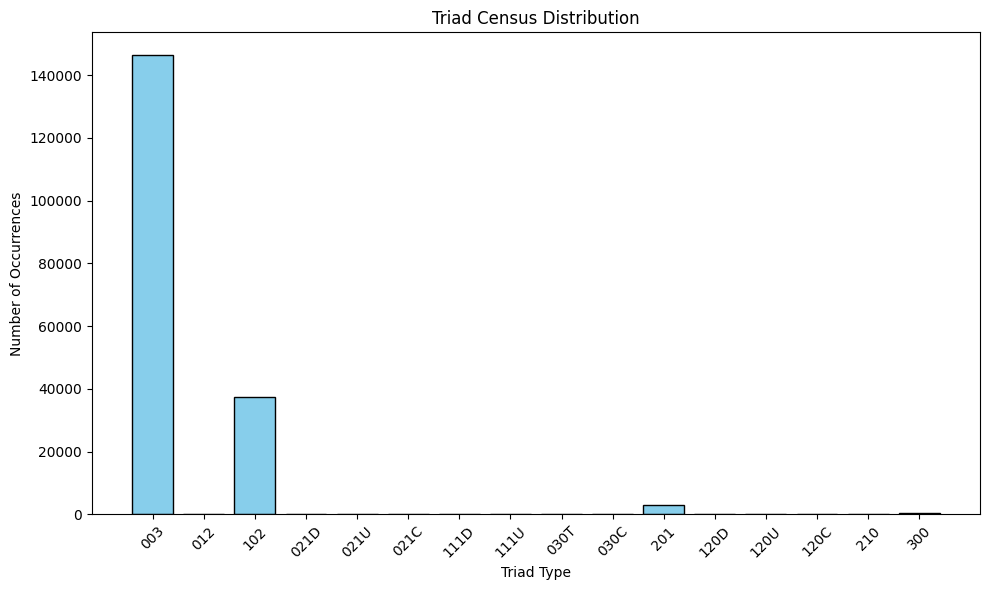

In [37]:
books_triads = compute_triad_census(G_books)
plot_triad_census(books_triads)

003: Number 285693976, 93.7073%
012: Number 0, 0.0000%
102: Number 18045809, 5.9190%
021D: Number 0, 0.0000%
021U: Number 0, 0.0000%
021C: Number 0, 0.0000%
111D: Number 0, 0.0000%
111U: Number 0, 0.0000%
030T: Number 0, 0.0000%
030C: Number 0, 0.0000%
201: Number 1038396, 0.3406%
120D: Number 0, 0.0000%
120U: Number 0, 0.0000%
120C: Number 0, 0.0000%
210: Number 0, 0.0000%
300: Number 101043, 0.0331%


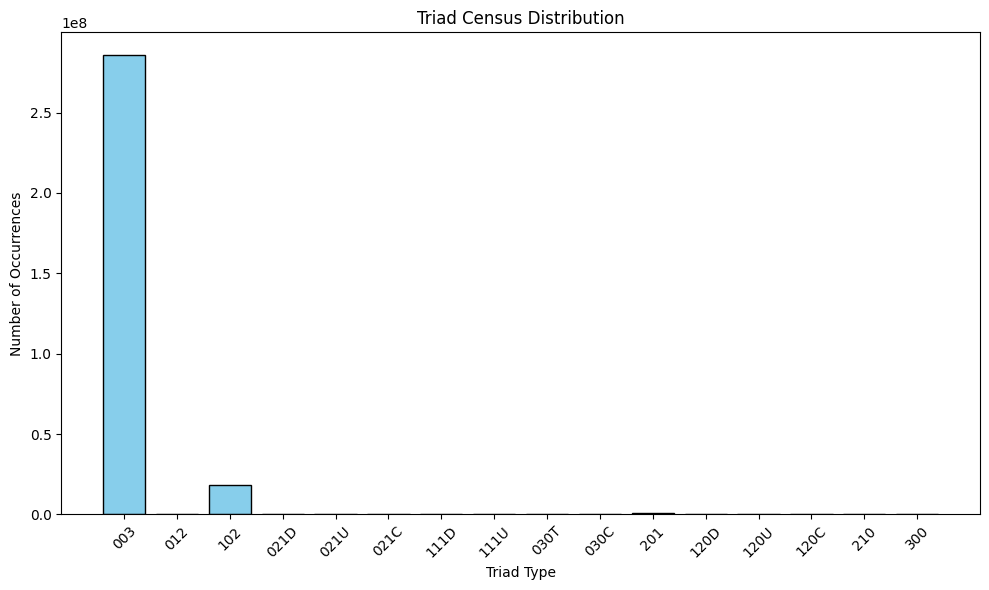

In [38]:
blogs_triads = compute_triad_census(G_blogs)
plot_triad_census(blogs_triads)

The political books network shows a relatively fragmented structure with a high proportion of isolated nodes (78.04% '003' triads). There are also numerous weakly connected node pairs (19.98% '102' triads), suggesting potential for local connections. Small clusters exist (0.30% '300' triads), along with some hub-like nodes (1.68% '201' triads), which indicate localized connectivity.

In contrast, the political blogs network exhibits a much higher percentage of isolated nodes (93.71% '003' triads), meaning the network is even more fragmented. The proportion of weakly connected pairs ('102' triads) is lower (5.92%), suggesting less connectivity between nodes compared to the books network. The presence of small clusters ('300' triads) is significantly lower (0.03%), and hub-like structures ('201' triads) are also minimal (0.34%).

Overall, the political books network, while fragmented, has more signs of weak connectivity and local clustering. The political blogs network, on the other hand, appears much more disconnected, with very few interactions beyond isolated pairs.

## Other

In [12]:
G_books.nodes

NodeView((1, 0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104))

In [78]:
import networkx as nx
import pandas as pd
import numpy as np
import altair as alt

def homophily(mixed_edges, total_edges, p_c, p_l, p_n):
    """
    Calculates homophily, a measure of the tendency for nodes with similar attributes to connect.

    Args:
        mixed_edges: The number of edges connecting nodes with different attributes.
        total_edges: The total number of edges in the network.
        p_c: Proportion of nodes with attribute 'c'.
        p_l: Proportion of nodes with attribute 'l'.
        p_n: Proportion of nodes with attribute 'n'.

    Returns:
        Homophily score: The difference between the expected and observed proportion of mixed edges.
    """

    # Calculate the expected probability of mixed edges
    mixed_edge_probability_c_l = 2 * p_c * p_l
    mixed_edge_probability_c_n = 2 * p_c * p_n
    mixed_edge_probability_l_n = 2 * p_l * p_n

    # Total expected probability of mixed edges
    total_expected_mixed_edges = mixed_edge_probability_c_l + mixed_edge_probability_c_n + mixed_edge_probability_l_n

    # Expected proportion of mixed edges
    expected_proportion_mixed_edges = total_expected_mixed_edges / 2 

    # Observed proportion of mixed edges
    observed_proportion_mixed_edges = mixed_edges / total_edges

    # Return homophily measure (difference between expected and observed)
    return expected_proportion_mixed_edges - observed_proportion_mixed_edges
# Assuming 'value' is the node attribute that contains labels 'c', 'l', 'n'
political_labels = [G_books.nodes[node].get('value', '') for node in G_books.nodes]  # Get 'value' for node labels (c, l, n)

# Get the proportions of each label (c, l, n)
p_c = political_labels.count('c') / len(political_labels)
p_l = political_labels.count('l') / len(political_labels)
p_n = political_labels.count('n') / len(political_labels)

# Find the total number of mixed edges in the network
mixed_edges = len([(s, t) for s, t in G_books.edges if G_books.nodes[s]['value'] != G_books.nodes[t]['value']])

# Get the total number of edges in the graph
total_edges = G_books.number_of_edges()

# Calculate homophily measure
obs_homophily = homophily(mixed_edges, total_edges, p_c, p_l, p_n)
print(f"Observed Homophily: {obs_homophily}")

# Create a simulation function for reshuffling the 'value' attribute
def simulate_mixed_edges(attribute, graph):
    # Reshuffle the node attributes and set them back
    attr_column = [graph.nodes[node].get(attribute, '') for node in graph.nodes]
    shuffled_attr_column = np.random.permutation(attr_column)  # Shuffle values
    # Set the shuffled values back as node attributes
    for node, new_attr in zip(graph.nodes, shuffled_attr_column):
        graph.nodes[node][attribute] = new_attr
    
    # Calculate mixed edges after reshuffling
    mixed_edges = len([(s, t) for s, t in graph.edges if graph.nodes[s][attribute] != graph.nodes[t][attribute]])
    return mixed_edges

# Simulate homophily 5000 times using permutation
sim_homophily = pd.DataFrame().assign(sim_homophily=[
    homophily(simulate_mixed_edges('value', G_books.copy()), total_edges, p_c, p_l, p_n) for i in range(5000)
])

# Plotting the results
histogram = alt.Chart(sim_homophily).mark_bar().encode(
    x=alt.X("sim_homophily:Q").bin(maxbins=20),
    y=alt.Y("count():Q")
)

# Add a red line for the observed homophily value
sim_homophily = sim_homophily.assign(obs_homophily=obs_homophily)
observed_difference = alt.Chart(sim_homophily).mark_rule(color="red", strokeDash=(8, 4)).encode(
    x=alt.X("obs_homophily")
)

# Combine histogram and the observed homophily line
histogram + observed_difference

# Calculate p-value for the observed homophily
p_value = np.mean(sim_homophily > obs_homophily)
print(f"P-value: {p_value}")


Observed Homophily: 0.1408616780045352
P-value: 0.0


In [79]:
import networkx as nx
import pandas as pd
import numpy as np
import altair as alt

def homophily(mixed_edges, total_edges, p_0, p_1):
    """
    Calculates homophily, a measure of the tendency for nodes with similar attributes to connect.

    Args:
        mixed_edges: The number of edges connecting nodes with different attributes.
        total_edges: The total number of edges in the network.
        p_0: Proportion of nodes with attribute '0'.
        p_1: Proportion of nodes with attribute '1'.

    Returns:
        Homophily score: The difference between the expected and observed proportion of mixed edges.
    """

    # Calculate the expected probability of mixed edges
    mixed_edge_probability_0_1 = 2 * p_0 * p_1

    # Expected proportion of mixed edges
    expected_proportion_mixed_edges = mixed_edge_probability_0_1 / 2  

    # Observed proportion of mixed edges
    observed_proportion_mixed_edges = mixed_edges / total_edges

    # Return homophily measure (difference between expected and observed)
    return expected_proportion_mixed_edges - observed_proportion_mixed_edges

# Extract node attributes (0 or 1)
political_labels = [G_blogs.nodes[node].get('value', '') for node in G_blogs.nodes]

# Compute proportions of each attribute
p_0 = political_labels.count(0) / len(political_labels)
p_1 = political_labels.count(1) / len(political_labels)

# Count mixed edges in the network
mixed_edges = len([(s, t) for s, t in G_blogs.edges if G_blogs.nodes[s]['value'] != G_blogs.nodes[t]['value']])

# Get the total number of edges
total_edges = G_blogs.number_of_edges()

# Compute homophily
obs_homophily = homophily(mixed_edges, total_edges, p_0, p_1)
print(f"Observed Homophily: {obs_homophily}")

# Function to simulate mixed edges
def simulate_mixed_edges(attribute, graph):
    attr_column = [graph.nodes[node].get(attribute, '') for node in graph.nodes]
    shuffled_attr_column = np.random.permutation(attr_column)  # Shuffle attributes
    for node, new_attr in zip(graph.nodes, shuffled_attr_column):
        graph.nodes[node][attribute] = new_attr  # Assign shuffled values

    # Recalculate mixed edges
    mixed_edges = len([(s, t) for s, t in graph.edges if graph.nodes[s][attribute] != graph.nodes[t][attribute]])
    return mixed_edges

# Perform 5000 simulations
sim_homophily = pd.DataFrame().assign(sim_homophily=[
    homophily(simulate_mixed_edges('value', G_blogs.copy()), total_edges, p_0, p_1) for _ in range(5000)
])

# Plot the results
histogram = alt.Chart(sim_homophily).mark_bar().encode(
    x=alt.X("sim_homophily:Q").bin(maxbins=20),
    y=alt.Y("count():Q")
)

# Add observed homophily as a red line
sim_homophily = sim_homophily.assign(obs_homophily=obs_homophily)
observed_difference = alt.Chart(sim_homophily).mark_rule(color="red", strokeDash=(8, 4)).encode(
    x=alt.X("obs_homophily")
)

# Combine histogram with observed homophily line
histogram + observed_difference

# Compute p-value
p_value = np.mean(sim_homophily > obs_homophily)
print(f"P-value: {p_value}")


Observed Homophily: 0.15540569877533833
P-value: 0.0


In [89]:
import networkx as nx
import pandas as pd
import numpy as np
import altair as alt

def modularity_test(G, num_simulations=100):
    """
    Tests the significance of the modularity score of a given network.

    Args:
        G: The NetworkX graph object.
        num_simulations: The number of simulations to perform.

    Returns:
        A tuple containing:
            - Observed modularity score.
            - P-value.
            - DataFrame containing simulated modularity scores.
    """

    # Get initial community assignment using a built-in algorithm
    communities = list(nx.algorithms.community.greedy_modularity_communities(G))

    # Calculate observed modularity
    observed_modularity = nx.algorithms.community.modularity(G, communities)

    # Simulate modularity
    simulated_modularity = []

    for _ in range(num_simulations):
        # Extract degree sequence as a list
        degree_sequence = list(G.degree())  # Get degrees as tuples

        # Unpack tuples into a list of integers
        degree_sequence = [d for d, _ in degree_sequence]

        # Create a random graph with the same degree sequence
        random_graph = nx.configuration_model(degree_sequence)
        random_communities = list(nx.algorithms.community.greedy_modularity_communities(random_graph))
        simulated_modularity.append(nx.algorithms.community.modularity(random_graph, random_communities))

    # Create a DataFrame for simulated modularity scores
    simulated_modularity_df = pd.DataFrame({'sim_modularity': simulated_modularity})

    # Plotting the results
    histogram = alt.Chart(simulated_modularity_df).mark_bar().encode(
        x=alt.X("sim_modularity:Q").bin(maxbins=20),  # Field name specified
        y=alt.Y("count():Q")
    )

    # Add a red line for the observed modularity value
    observed_difference = alt.Chart(pd.DataFrame({'obs_modularity': [observed_modularity]})).mark_rule(color="red", strokeDash=(8, 4)).encode(
        x=alt.X('obs_modularity:Q')
    )

    # Combine histogram and the observed modularity line
    chart = histogram + observed_difference

    # Calculate p-value
    p_value = np.mean(np.array(simulated_modularity) >= observed_modularity)

    return observed_modularity, p_value, simulated_modularity_df, chart


In [90]:
# Example usage:
observed_modularity, p_value, sim_df, chart = modularity_test(G_books)

print(f"Observed Modularity: {observed_modularity}")
print(f"P-value: {p_value}")

# Display the plot
chart.show()

Observed Modularity: 0.5019744859395006
P-value: 0.0


alt.LayerChart(...)

In [91]:
# Example usage:
observed_modularity, p_value, sim_df, chart = modularity_test(G_blogs, num_simulations=50)

print(f"Observed Modularity: {observed_modularity}")
print(f"P-value: {p_value}")

# Display the plot
chart.show()

Observed Modularity: 0.4270013658804194
P-value: 0.0


alt.LayerChart(...)

In [92]:
import networkx as nx
import numpy as np

def compute_small_worldness(G, num_simulations=100):
    """
    Calculates the small-worldness coefficient of a given graph.

    Args:
        G: The NetworkX graph object.
        num_simulations: The number of random graphs to generate for comparison.

    Returns:
        The small-worldness coefficient.
    """

    # Calculate clustering coefficient of the original graph
    C = nx.average_clustering(G)

    # Calculate average shortest path length of the original graph
    try:
        L = nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        # In case the graph is disconnected
        L = float('inf')

    # Calculate clustering coefficient and average shortest path length for random graphs
    C_random_list = []
    L_random_list = []
    for _ in range(num_simulations):
        # Generate a random graph with the same number of nodes and edges
        random_graph = nx.erdos_renyi_graph(G.number_of_nodes(), 0.5)  # Erdős–Rényi model for random graphs
        while not nx.is_connected(random_graph):
            random_graph = nx.erdos_renyi_graph(G.number_of_nodes(), 0.5)

        try:
            C_random_list.append(nx.average_clustering(random_graph))
            L_random_list.append(nx.average_shortest_path_length(random_graph))
        except (nx.NetworkXError, ZeroDivisionError):
            # Handle cases where random graphs are disconnected or have no edges
            C_random_list.append(0)
            L_random_list.append(float('inf'))

    # Calculate average clustering and path length for random graphs
    C_random_avg = np.mean(C_random_list)
    L_random_avg = np.mean(L_random_list)

    # Calculate small-worldness
    if L_random_avg == 0 or C_random_avg == 0:
        small_worldness = 0
    else:
        small_worldness = (C / C_random_avg) / (L / L_random_avg)

    return small_worldness


In [93]:
small_worldness_value = compute_small_worldness(G_books)
print(f"Small-Worldness: {small_worldness_value}")

Small-Worldness: 0.4758498802063451


In [94]:
small_worldness_value = compute_small_worldness(G_blogs, num_simulations=50)
print(f"Small-Worldness: {small_worldness_value}")

Small-Worldness: 0.0


In [50]:
from collections import Counter
import numpy as np
from scipy.stats import powerlaw

# Scale-Freeness
def compute_scale_freeness(G):
    # Get the degree of each node
    degrees = [degree for node, degree in G.degree()]
    
    # Count frequency of each degree
    degree_count = Counter(degrees)
    degree_values = np.array(list(degree_count.keys()))
    degree_freq = np.array(list(degree_count.values()))
    
    # Fit a power law distribution to the degree distribution
    try:
        # Using the powerlaw package to fit the data
        import powerlaw
        fit = powerlaw.Fit(degrees)  # Fit the degree distribution to a power law
        alpha = fit.alpha  # The exponent of the power-law
        r_value = fit.R  # The goodness of fit
        scale_freeness = (alpha, r_value)
    except Exception as e:
        print(str(e))
        scale_freeness = None  # In case fitting fails or the library is missing
    
    return scale_freeness


In [51]:
scale_freeness_value = compute_scale_freeness(G_books)

print(f"Scale-Freeness: {scale_freeness_value}")

Calculating best minimal value for power law fit
Rmin progress: 95%
Scale-Freeness: None


In [52]:
scale_freeness_value = compute_scale_freeness(G_blogs)

print(f"Scale-Freeness: {scale_freeness_value}")

Calculating best minimal value for power law fit
Rmin progress: 99%
Scale-Freeness: None


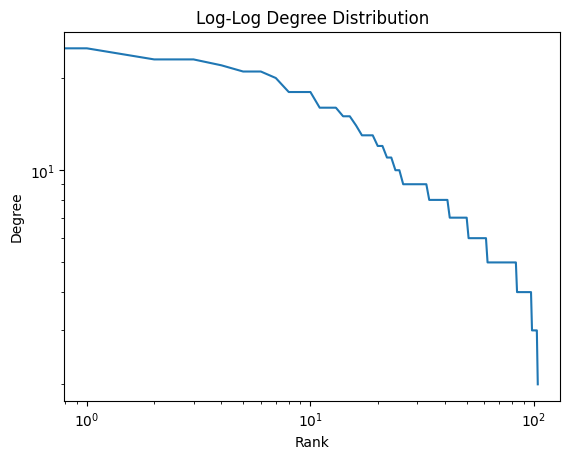

In [53]:
degrees = sorted(dict(G_books.degree()).values(), reverse=True)

plt.loglog(degrees)
plt.title('Log-Log Degree Distribution')
plt.xlabel('Rank')
plt.ylabel('Degree')
plt.show()


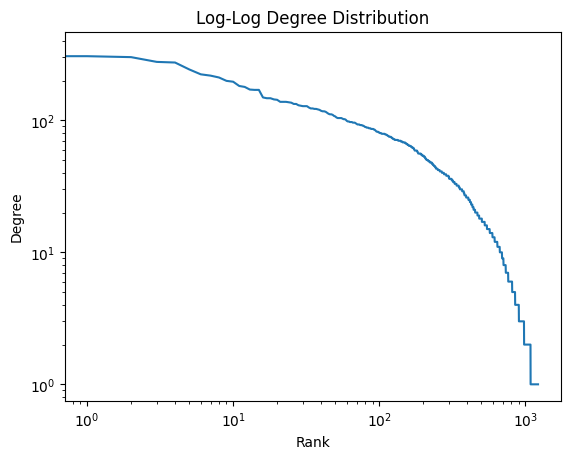

In [54]:
degrees = sorted(dict(G_blogs.degree()).values(), reverse=True)

plt.loglog(degrees)
plt.title('Log-Log Degree Distribution')
plt.xlabel('Rank')
plt.ylabel('Degree')
plt.show()
